# RFM Segmentation Online Sales

RFM (Recency, Frequency, Monetary) segmentation is conducted on the online sales dataset. Previously this data set was explored in this [sales_dasbhoard_eda notebook]().

sdf;sd;lsdfa

The purpose of this notebook is to explore census data for use in developing market segmnt insights. An initial exploration of Several datasets is performed including clustering and geographic concentrations by 
 * Race, 
 * Ethnicity
 * Education
 * Income
 * Industry 
 * Ocupation


Libraries and Helper functions
* Cartopy - Python package for geospatial data processing, maps, and geospatial analyss
* Kmeans clustering
* Helper function in the file "./census_segmentation_helpers.py" ... 
    * Kmeans Clustering 
    * Grid plot
    * Elbow Method
    * Silhouette Plots
    * Geo Plots ... cartopy

# Load Data

Imports

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import beautifulplots as bp


online sales csv

In [6]:
data_path = "./data_onlinesales"
filename = "online_sales_uci.csv"
df_sales = pd.read_csv(f'{data_path}/{filename}', parse_dates=["InvoiceDate"] )

df_sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,RepeatPurchase
0,545279,21238,RED RETROSPOT CUP,6,2011-03-01,0.85,17811.0,United Kingdom,Repeat Customer
1,545279,22844,VINTAGE CREAM DOG FOOD CONTAINER,1,2011-03-01,8.50,17811.0,United Kingdom,Repeat Customer
2,545279,21731,RED TOADSTOOL LED NIGHT LIGHT,4,2011-03-01,1.65,17811.0,United Kingdom,Repeat Customer
3,545279,21240,BLUE POLKADOT CUP,12,2011-03-01,0.85,17811.0,United Kingdom,Repeat Customer
4,545279,22845,VINTAGE CREAM CAT FOOD CONTAINER,12,2011-03-01,5.55,17811.0,United Kingdom,Repeat Customer


# Load Data and Pre-process 

#### The Five Data Sets - overview of Servey's ... the data use herein is from ACS 5-year. The only dataset with enough data to get a general idea across all Zip Codes (ZTAs)
* https://towardsdatascience.com/accessing-census-data-with-python-3e2f2b56e20d
* CS 1-year estimates (2012–2018) For areas with populations 65,000+, most frequently updated but with the lowest “resolution” since it excludes areas with low population and has the smallest sample size
* ACS 1-year supplemental estimates (2014–2017) Supplemental dataset that focuses on lower population areas of 20,000+
* ACS 3-year estimates (2010–2012 to 2011–2013) For areas with populations 20,000+, very much the middle ground between the 1 and 5 years. Currently discounted by the Census Bureau but old versions can still be accessed.
* ACS 5-year estimates (2005–2009 to 2014–2018) Data for all areas, highest resolution and largest sample size but the least current
* Census 2010 Summary File 1 Counts every resident of the US, updated every 10 years.

In [4]:
# Load Census Data Sets

# Population Age and Sex
# American Community Servey , 5 year, Populaton Age and Sex, by Zip COde (All ZTA), Table = S1501
read_filename='./data_census/acsdp5y2018dp05_population_agesex.csv'
print('\n', read_filename)
df_popagesex= pd.read_csv(read_filename, dtype={'ZipCode': str} )
display(df_popagesex.head(3))

# Education Attainment
read_filename='./data_census/acsst5y2018S1501_edattain_allzcta.csv'
print('\n', read_filename)
df_edattain= pd.read_csv(read_filename, dtype={'ZipCode': str})
df_edattain.rename(columns={"Pop25YAO": "Pop25YAO.edattain"},inplace=True)
display(df_edattain.head(3))

# Race Ethnicity
read_filename='./data_census/acsdt5y2018S2502_race_ethnicity_allzcta.csv'
print('\n', read_filename)
df_raceethnicity= pd.read_csv(read_filename, dtype={'ZipCode': str})
display(df_raceethnicity.head(3))

# Earnings
read_filename='./data_census/acsst5y2018S2001_earnings_allzcta.csv'
print('\n', read_filename)
df_earnings= pd.read_csv(read_filename, dtype={'ZipCode': str })
display(df_earnings.head(3))

# Employment
read_filename='./data_census/acss5y2018S2301_employment_status_allzcta.csv'
print('\n', read_filename)
df_employment= pd.read_csv(read_filename, dtype={'ZipCode': str})
display(df_employment.head(3))

# Housing
read_filename='./data_census/acss5y2018S2502_housing_owner_renter_allzcta.csv'
print('\n', read_filename)
df_housing= pd.read_csv(read_filename, dtype={'ZipCode': str})
display(df_housing.head(3))

# Occupation
read_filename='./data_census/acss5y2018S2402_occupation_allzcta.csv'
print('\n', read_filename)
df_occupation= pd.read_csv(read_filename, dtype={'ZipCode': str})
df_occupation.rename(columns={'Pop16YAO':'Pop16YAO.occupation'},inplace=True)
display(df_occupation.head(3))

# Industry
read_filename='./data_census/acss5y2018S2404_industry_allzcta.csv'
print('\n', read_filename)
df_industry= pd.read_csv(read_filename, dtype={'ZipCode': str})
df_industry.rename(columns={'Pop16YAO':'Pop16YAO.industry'},inplace=True)
display(df_industry.head(3))





 ./data_census/acsdp5y2018dp05_population_agesex.csv


,ZipCode,TotalPopulation,MalePercent,FemalePercent,Under5YPercent,5to9YPercent,10to14YPercent,15to19YPercent,20to24YPercent,25to34YPercent,35to44YPercent,45to54YPercent,55to59YPercent,60to64YPercent,65to74YPercent,75to84YPercent,85AndOverPercent
0,01001,17621,47.1,52.9,4.5,5.4,6.1,3.6,3.7,12.6,12.6,13.4,7.2,6.7,11.6,7.6,4.9
1,01002,30066,48.5,51.5,3.1,3.2,3.3,14.5,29.9,11.0,6.6,7.9,4.2,4.5,6.7,3.1,2.0
2,01003,11238,51.3,48.7,0.0,0.0,0.0,50.1,48.8,0.6,0.1,0.0,0.3,0.1,0.0,0.0,0.0



 ./data_census/acsst5y2018S1501_edattain_allzcta.csv


,ZipCode,Pop25YAO.edattain,LessThan9th25YAO,9To12NoDip25YAO,HSGrad25YAO,AssocDeg25YAO,BachDeg25YAO,GradOrProfDeg25YAO,HSGradOrHigher25YAO
0,01001,13508,293,858,3816,1183,2601,1789,12357
1,01002,13857,379,291,1860,778,3541,5745,13187
2,01003,118,0,27,14,10,13,5,91



 ./data_census/acsdt5y2018S2502_race_ethnicity_allzcta.csv


,ZipCode,NonHispanic,WhiteAlone,AfricanAmericanAlone,AmericanIndianAlaskaNative,AsianAlone,NativeHawaiianPacificIslander,OtherNonHispanic,Hispanic
0,43964,8615,8209,256,2,21,0,127,27
1,28216,47039,12020,32646,20,1032,0,1321,4077
2,28277,66433,47299,6154,171,10486,0,2323,5172



 ./data_census/acsst5y2018S2001_earnings_allzcta.csv


,ZipCode,Pop16YAO,MedianEarnings16YAO,MedianEarnings25YAO,MedianEarningsBachelors25YAO,MedianEarningsGradOrProfDeg25YAO
0,00601,4165.0,14448.0,15158.0,19840.0,27333.0
1,00602,12288.0,13322.0,14134.0,19317.0,29073.0
2,00603,13838.0,15980.0,16961.0,23089.0,40570.0



 ./data_census/acss5y2018S2301_employment_status_allzcta.csv


,ZipCode,Pop16YAO,UnEmpRate16YAO,UnEmpRate20to64Y
0,01001,14601.0,3.4,3.8
1,01002,26816.0,5.9,5.0
2,01003,11238.0,18.4,12.7



 ./data_census/acss5y2018S2502_housing_owner_renter_allzcta.csv


,ZipCode,OccupiedUnits,OwnerOccupiedUnits,RenterOccupiedUnits
0,01001,7481,5484,1997
1,01002,9877,4578,5299
2,01003,36,4,32



 ./data_census/acss5y2018S2402_occupation_allzcta.csv


,ZipCode,Pop16YAO.occupation,MBSA,MBSA_MBF,MBSA_CES,MBSA_ELCAM,MBSA_HPT,SE,SAO,NCS,NCS_FFF,NCS_IMR,NCS_CE,PTM
0,01001,6023.0,2769.0,1151.0,382.0,860.0,376.0,682.0,1097.0,529.0,0.0,274.0,255.0,946.0
1,01002,6476.0,3942.0,1387.0,551.0,1637.0,367.0,853.0,1032.0,302.0,0.0,114.0,188.0,347.0
2,01003,180.0,51.0,35.0,10.0,6.0,0.0,68.0,32.0,29.0,13.0,16.0,0.0,0.0



 ./data_census/acss5y2018S2404_industry_allzcta.csv


,ZipCode,Pop16YAO.industry,Male16AO,MalePct16AO,Fem16AO,FemPct16AO,PopAFFHM,MaleAFFHM,MalePctAFFHM,FemAFFHM,...,PopO,MaleO,MalePctO,FemO,FemPctO,PopP,MaleP,MalePctP,FemP,FemPctP
0,01001,6023.0,3382.0,56.2,2641.0,43.8,0.0,0.0,NaN,0.0,...,121.0,59.0,48.8,62.0,51.2,335.0,225.0,67.2,110.0,32.8
1,01002,6476.0,3663.0,56.6,2813.0,43.4,3.0,3.0,100.0,0.0,...,207.0,88.0,42.5,119.0,57.5,138.0,73.0,52.9,65.0,47.1
2,01003,180.0,77.0,42.8,103.0,57.2,13.0,13.0,100.0,0.0,...,16.0,16.0,100.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN


# Normalize Data Tables 

* consistent scale and column representations (not as in the DB table normalize)

In [5]:
# Normalize Tables - ... consistent scale and column representations

# PopAgeSex
df_popagesex['24YAndUnderPercent']=df_popagesex['Under5YPercent']+df_popagesex['5to9YPercent'] +df_popagesex['10to14YPercent']+df_popagesex['15to19YPercent']+df_popagesex['20to24YPercent'] 
df_popagesex['25To44YPercent']=df_popagesex['25to34YPercent']+df_popagesex['35to44YPercent']
df_popagesex['45To64YPercent']=df_popagesex['45to54YPercent']+df_popagesex['55to59YPercent']+df_popagesex['60to64YPercent']
df_popagesex['65YAndAbovePercent']= df_popagesex['65to74YPercent'] + df_popagesex['75to84YPercent']+df_popagesex['85AndOverPercent']
print('df_popagesex')
display(df_popagesex.head(3))


# EdAttain
df_edattain['LessThan9thPercent']=100*df_edattain['LessThan9th25YAO']/df_edattain['Pop25YAO.edattain']
df_edattain['9To12NoDipPercent']=100*df_edattain['9To12NoDip25YAO']/df_edattain['Pop25YAO.edattain']
df_edattain['HSGradPercent']=100*df_edattain['HSGrad25YAO']/df_edattain['Pop25YAO.edattain']
df_edattain['AssocDegPercent']=100*df_edattain['AssocDeg25YAO']/df_edattain['Pop25YAO.edattain']
df_edattain['BachDegPercent']=100*df_edattain['BachDeg25YAO']/df_edattain['Pop25YAO.edattain']
df_edattain['GradOrProfDegPercent']=100*df_edattain['GradOrProfDeg25YAO']/df_edattain['Pop25YAO.edattain']
df_edattain['HSGradOrHigherPercent']=100*df_edattain['HSGradOrHigher25YAO']/df_edattain['Pop25YAO.edattain']
print('df_edattain')
display(df_edattain.head(3))

# Race Ethnicity
df_raceethnicity['TotalPopulation']=df_raceethnicity['NonHispanic']+df_raceethnicity['Hispanic']
df_raceethnicity['WhitePercent']=100*df_raceethnicity['WhiteAlone']/df_raceethnicity['TotalPopulation']
df_raceethnicity['AfricanAmericanPercent']=100*df_raceethnicity['AfricanAmericanAlone']/df_raceethnicity['TotalPopulation']
df_raceethnicity['AmericanIndianAlaskaNativePercent']=100*df_raceethnicity['AmericanIndianAlaskaNative']/df_raceethnicity['TotalPopulation']
df_raceethnicity['AsianPercent']=100*df_raceethnicity['AsianAlone']/df_raceethnicity['TotalPopulation']
df_raceethnicity['NativeHawaiianPacificIslanderPercent']=100*df_raceethnicity['NativeHawaiianPacificIslander']/df_raceethnicity['TotalPopulation']
df_raceethnicity['HispanicPercent']=100*df_raceethnicity['Hispanic']/df_raceethnicity['TotalPopulation']
df_raceethnicity['OtherNonHispanicPercent']=100*df_raceethnicity['OtherNonHispanic']/df_raceethnicity['TotalPopulation']
print('df_raceethnicity')
display(df_raceethnicity.head(3))


# Housing
df_housing['OwnerOccupiedPercent']=100*df_housing['OwnerOccupiedUnits']/df_housing['OccupiedUnits']
df_housing['RenterOccupiedPercent']=100*df_housing['RenterOccupiedUnits']/df_housing['OccupiedUnits']
print('\ndf_housing')
display(df_housing.head(3))

# Earnings Relative to 100K
df_earnings['MedianEarnings16YAORel100K']=100*df_earnings['MedianEarnings16YAO']/100000
print('\ndf_earnings')
display(df_earnings.head(3))


# Occupation
df_occupation['MBSA_ManagementBusFinPercent']=100*df_occupation['MBSA_MBF']/df_occupation['Pop16YAO.occupation']
df_occupation['MBSA_ComputerEngineeringSciencePercent']=100*df_occupation['MBSA_CES']/df_occupation['Pop16YAO.occupation']
df_occupation['MBSA_EduLegalComServiceArtsMediaPercent']=100*df_occupation['MBSA_ELCAM']/df_occupation['Pop16YAO.occupation']
df_occupation['MBSA_HealthcarePractionerAndTechnicalPercent']=100*df_occupation['MBSA_HPT']/df_occupation['Pop16YAO.occupation']
df_occupation['ServicePercent']=100*df_occupation['SE']/df_occupation['Pop16YAO.occupation']
df_occupation['SalesAndOfficePercent']=100*df_occupation['SAO']/df_occupation['Pop16YAO.occupation']
df_occupation['NCS_FarmingFishingForestryPercent']=100*df_occupation['NCS_FFF']/df_occupation['Pop16YAO.occupation']
df_occupation['NCS_InstallationMaintenanceRepairPercent']=100*df_occupation['NCS_IMR']/df_occupation['Pop16YAO.occupation']
df_occupation['NCS_ConstructionExtractionPercent']=100*df_occupation['NCS_CE']/df_occupation['Pop16YAO.occupation']
df_occupation['ProductionTransportationMaterialMovingPercent']=100*df_occupation['PTM']/df_occupation['Pop16YAO.occupation']
print('\ndf_occupation')
display(df_occupation.head(3))


# Industry
df_industry['AggFarmFishMingPercent']=100*df_industry['PopAFFHM']/df_industry['Pop16YAO.industry']
df_industry['ConstructionPercent']=100*df_industry['PopC']/df_industry['Pop16YAO.industry']
df_industry['ManufacturingPercent']=100*df_industry['PopM']/df_industry['Pop16YAO.industry']
df_industry['WholesaleTradePercent']=100*df_industry['PopWS']/df_industry['Pop16YAO.industry']
df_industry['EducationHealthcareSocialPercent']=100*df_industry['PopEHS']/df_industry['Pop16YAO.industry']
df_industry['RetailTradePercent']=100*df_industry['PopR']/df_industry['Pop16YAO.industry']
df_industry['TransportationWarehouseUtilitiesPercent']=100*df_industry['PopTWU']/df_industry['Pop16YAO.industry']
df_industry['ArtsEntertainmentRecAccomFoodPercent']=100*df_industry['PopAERA']/df_industry['Pop16YAO.industry']
df_industry['OtherPercent']=100*df_industry['PopO']/df_industry['Pop16YAO.industry']
df_industry['InformationPercent']=100*df_industry['PopI']/df_industry['Pop16YAO.industry']
df_industry['FinanceInsuranceRealestateRentalPercent']=100*df_industry['PopFIR']/df_industry['Pop16YAO.industry']
df_industry['PublicAdminPercent']=100*df_industry['PopP']/df_industry['Pop16YAO.industry']
print('\ndf_industry')
display(df_industry.head(3))



df_popagesex


,ZipCode,TotalPopulation,MalePercent,FemalePercent,Under5YPercent,5to9YPercent,10to14YPercent,15to19YPercent,20to24YPercent,25to34YPercent,...,45to54YPercent,55to59YPercent,60to64YPercent,65to74YPercent,75to84YPercent,85AndOverPercent,24YAndUnderPercent,25To44YPercent,45To64YPercent,65YAndAbovePercent
0,01001,17621,47.1,52.9,4.5,5.4,6.1,3.6,3.7,12.6,...,13.4,7.2,6.7,11.6,7.6,4.9,23.3,25.2,27.3,24.1
1,01002,30066,48.5,51.5,3.1,3.2,3.3,14.5,29.9,11.0,...,7.9,4.2,4.5,6.7,3.1,2.0,54.0,17.6,16.6,11.8
2,01003,11238,51.3,48.7,0.0,0.0,0.0,50.1,48.8,0.6,...,0.0,0.3,0.1,0.0,0.0,0.0,98.9,0.7,0.4,0.0


df_edattain


,ZipCode,Pop25YAO.edattain,LessThan9th25YAO,9To12NoDip25YAO,HSGrad25YAO,AssocDeg25YAO,BachDeg25YAO,GradOrProfDeg25YAO,HSGradOrHigher25YAO,LessThan9thPercent,9To12NoDipPercent,HSGradPercent,AssocDegPercent,BachDegPercent,GradOrProfDegPercent,HSGradOrHigherPercent
0,01001,13508,293,858,3816,1183,2601,1789,12357,2.169085,6.351792,28.249926,8.757773,19.255256,13.244004,91.479123
1,01002,13857,379,291,1860,778,3541,5745,13187,2.735080,2.100022,13.422819,5.614491,25.553872,41.459190,95.164899
2,01003,118,0,27,14,10,13,5,91,0.000000,22.881356,11.864407,8.474576,11.016949,4.237288,77.118644


df_raceethnicity


,ZipCode,NonHispanic,WhiteAlone,AfricanAmericanAlone,AmericanIndianAlaskaNative,AsianAlone,NativeHawaiianPacificIslander,OtherNonHispanic,Hispanic,TotalPopulation,WhitePercent,AfricanAmericanPercent,AmericanIndianAlaskaNativePercent,AsianPercent,NativeHawaiianPacificIslanderPercent,HispanicPercent,OtherNonHispanicPercent
0,43964,8615,8209,256,2,21,0,127,27,8642,94.989586,2.962277,0.023143,0.242999,0.0,0.312428,1.469567
1,28216,47039,12020,32646,20,1032,0,1321,4077,51116,23.515142,63.866500,0.039127,2.018937,0.0,7.975976,2.584318
2,28277,66433,47299,6154,171,10486,0,2323,5172,71605,66.055443,8.594372,0.238810,14.644229,0.0,7.222959,3.244187



df_housing


,ZipCode,OccupiedUnits,OwnerOccupiedUnits,RenterOccupiedUnits,OwnerOccupiedPercent,RenterOccupiedPercent
0,01001,7481,5484,1997,73.305708,26.694292
1,01002,9877,4578,5299,46.350106,53.649894
2,01003,36,4,32,11.111111,88.888889



df_earnings


,ZipCode,Pop16YAO,MedianEarnings16YAO,MedianEarnings25YAO,MedianEarningsBachelors25YAO,MedianEarningsGradOrProfDeg25YAO,MedianEarnings16YAORel100K
0,00601,4165.0,14448.0,15158.0,19840.0,27333.0,14.448
1,00602,12288.0,13322.0,14134.0,19317.0,29073.0,13.322
2,00603,13838.0,15980.0,16961.0,23089.0,40570.0,15.980



df_occupation


,ZipCode,Pop16YAO.occupation,MBSA,MBSA_MBF,MBSA_CES,MBSA_ELCAM,MBSA_HPT,SE,SAO,NCS,...,MBSA_ManagementBusFinPercent,MBSA_ComputerEngineeringSciencePercent,MBSA_EduLegalComServiceArtsMediaPercent,MBSA_HealthcarePractionerAndTechnicalPercent,ServicePercent,SalesAndOfficePercent,NCS_FarmingFishingForestryPercent,NCS_InstallationMaintenanceRepairPercent,NCS_ConstructionExtractionPercent,ProductionTransportationMaterialMovingPercent
0,01001,6023.0,2769.0,1151.0,382.0,860.0,376.0,682.0,1097.0,529.0,...,19.110078,6.342354,14.278599,6.242736,11.323261,18.213515,0.000000,4.549228,4.233771,15.706459
1,01002,6476.0,3942.0,1387.0,551.0,1637.0,367.0,853.0,1032.0,302.0,...,21.417542,8.508338,25.277949,5.667078,13.171711,15.935763,0.000000,1.760346,2.903027,5.358246
2,01003,180.0,51.0,35.0,10.0,6.0,0.0,68.0,32.0,29.0,...,19.444444,5.555556,3.333333,0.000000,37.777778,17.777778,7.222222,8.888889,0.000000,0.000000



df_industry


,ZipCode,Pop16YAO.industry,Male16AO,MalePct16AO,Fem16AO,FemPct16AO,PopAFFHM,MaleAFFHM,MalePctAFFHM,FemAFFHM,...,ManufacturingPercent,WholesaleTradePercent,EducationHealthcareSocialPercent,RetailTradePercent,TransportationWarehouseUtilitiesPercent,ArtsEntertainmentRecAccomFoodPercent,OtherPercent,InformationPercent,FinanceInsuranceRealestateRentalPercent,PublicAdminPercent
0,01001,6023.0,3382.0,56.2,2641.0,43.8,0.0,0.0,NaN,0.0,...,14.627262,2.639880,25.037357,12.170015,8.135481,4.366595,2.008966,1.942554,7.554375,5.562012
1,01002,6476.0,3663.0,56.6,2813.0,43.4,3.0,3.0,100.0,0.0,...,4.122915,2.192712,50.185300,8.199506,3.242742,6.578135,3.196418,1.266214,3.520692,2.130945
2,01003,180.0,77.0,42.8,103.0,57.2,13.0,13.0,100.0,0.0,...,0.000000,0.000000,24.444444,12.777778,0.000000,28.888889,8.888889,0.000000,6.666667,0.000000


In [4]:
df_popagesex.describe()

,TotalPopulation,MalePercent,FemalePercent,Under5YPercent,5to9YPercent,10to14YPercent,15to19YPercent,20to24YPercent,25to34YPercent,35to44YPercent,45to54YPercent,55to59YPercent,60to64YPercent,65to74YPercent,75to84YPercent,85AndOverPercent,24YAndUnderPercent,25To44YPercent,45To64YPercent,65YAndAbovePercent
count,32989.000000,32670.000000,32670.000000,32670.000000,32670.000000,32670.000000,32670.000000,32670.000000,32670.00000,32670.000000,32670.000000,32670.000000,32670.000000,32670.000000,32670.000000,32670.00000,32670.000000,32670.000000,32670.000000,32670.000000
mean,9787.795235,50.189752,49.810422,5.454876,5.780349,6.086440,6.405182,6.039253,11.55356,11.352354,13.410496,7.666312,7.292914,11.130340,5.697983,2.13094,29.766100,22.905914,28.369721,18.959262
std,14561.770176,6.874298,6.874232,3.447089,3.276557,3.373144,5.662840,5.645497,6.30143,5.025354,5.877090,5.026904,4.962195,7.613395,5.340297,2.91914,10.972288,8.217692,9.219633,10.883961
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,702.000000,47.800000,48.100000,3.700000,4.200000,4.400000,4.400000,3.600000,8.40000,9.300000,11.100000,5.700000,5.200000,7.600000,3.300000,0.80000,25.300000,19.300000,24.400000,13.300000
50%,2775.000000,49.600000,50.400000,5.400000,5.800000,6.100000,6.000000,5.400000,11.20000,11.600000,13.200000,7.200000,6.700000,9.900000,4.900000,1.70000,29.900000,23.000000,27.900000,17.300000
75%,13208.000000,51.900000,52.200000,7.000000,7.300000,7.600000,7.500000,7.100000,14.10000,13.500000,15.500000,8.800000,8.500000,12.800000,6.700000,2.70000,34.200000,26.600000,31.800000,22.000000
max,122814.000000,100.000000,100.000000,75.000000,59.300000,56.500000,99.500000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.100000,100.000000


# Join into Wide Table

In [6]:
# Join tables 

# PopAgeSex and RaceEthnicity
col_popagesex=['ZipCode','TotalPopulation','24YAndUnderPercent','25To44YPercent','45To64YPercent','65YAndAbovePercent']
col_raceth=['ZipCode','TotalPopulation','WhitePercent','AfricanAmericanPercent','AmericanIndianAlaskaNativePercent',
           'AsianPercent','NativeHawaiianPacificIslanderPercent','HispanicPercent','OtherNonHispanicPercent']
df=df_popagesex[col_popagesex].set_index('ZipCode').join(df_raceethnicity[col_raceth ].set_index('ZipCode'),lsuffix=".popagesex",rsuffix=".raceethnicity").reset_index()


# Education Attainment

col_edattain=['ZipCode','Pop25YAO.edattain','LessThan9th25YAO','9To12NoDip25YAO', 'HSGrad25YAO','AssocDeg25YAO',
              'BachDeg25YAO','GradOrProfDeg25YAO', 'HSGradOrHigher25YAO',
              'LessThan9thPercent','9To12NoDipPercent','HSGradPercent','AssocDegPercent','BachDegPercent',
              'GradOrProfDegPercent','HSGradOrHigherPercent']
df=df.set_index('ZipCode').join(df_edattain[col_edattain].set_index('ZipCode')).reset_index()

# Earnings
col_earn=['ZipCode','Pop16YAO','MedianEarnings16YAO','MedianEarningsBachelors25YAO','MedianEarningsGradOrProfDeg25YAO','MedianEarnings16YAORel100K']
df=df.set_index('ZipCode').join(df_earnings[col_earn].set_index('ZipCode')).reset_index()


# Employment
employment_cols=['ZipCode',  'UnEmpRate16YAO',  'UnEmpRate20to64Y']
df=df.set_index('ZipCode').join(df_employment[ employment_cols ].set_index('ZipCode'),lsuffix='.earnings',rsuffix='.employment').reset_index()

# Housing
col_hou=['ZipCode','OccupiedUnits','OwnerOccupiedPercent','RenterOccupiedPercent']
df=df.set_index('ZipCode').join(df_housing[col_hou].set_index('ZipCode')).reset_index()

# Occupation
col_occ=['ZipCode','Pop16YAO.occupation','MBSA_ManagementBusFinPercent','MBSA_ComputerEngineeringSciencePercent','MBSA_EduLegalComServiceArtsMediaPercent',
                 'MBSA_HealthcarePractionerAndTechnicalPercent','ServicePercent','SalesAndOfficePercent',
                 'NCS_FarmingFishingForestryPercent','NCS_InstallationMaintenanceRepairPercent','NCS_ConstructionExtractionPercent',
                 'ProductionTransportationMaterialMovingPercent']
df=df.set_index('ZipCode').join(df_occupation[col_occ].set_index('ZipCode')).reset_index()



# Industry
col_ind=['ZipCode','Pop16YAO.industry','AggFarmFishMingPercent','ConstructionPercent','ManufacturingPercent', 
         'WholesaleTradePercent','EducationHealthcareSocialPercent',
         'RetailTradePercent','TransportationWarehouseUtilitiesPercent','ArtsEntertainmentRecAccomFoodPercent',
         'OtherPercent','InformationPercent','FinanceInsuranceRealestateRentalPercent','PublicAdminPercent']
df=df.set_index('ZipCode').join(df_industry[col_ind].set_index('ZipCode'),lsuffix='.occupation',rsuffix='.industry').reset_index()

# Display
pd.set_option('display.max_columns', None)  # Set it to None to display all columns in the dataframe
print(df.shape)
#print(df.columns)
print('df.T')
display(df.head(3).T)


(32989, 63)
df.T


,0,1,2
ZipCode,01001,01002,01003
TotalPopulation.popagesex,17621,30066,11238
24YAndUnderPercent,23.3,54.0,98.9
25To44YPercent,25.2,17.6,0.7
45To64YPercent,27.3,16.6,0.4
...,...,...,...
ArtsEntertainmentRecAccomFoodPercent,4.366595,6.578135,28.888889
OtherPercent,2.008966,3.196418,8.888889
InformationPercent,1.942554,1.266214,0.0
FinanceInsuranceRealestateRentalPercent,7.554375,3.520692,6.666667


In [7]:
display(df.head(3))
df.describe()

,ZipCode,TotalPopulation.popagesex,24YAndUnderPercent,25To44YPercent,45To64YPercent,65YAndAbovePercent,TotalPopulation.raceethnicity,WhitePercent,AfricanAmericanPercent,AmericanIndianAlaskaNativePercent,AsianPercent,NativeHawaiianPacificIslanderPercent,HispanicPercent,OtherNonHispanicPercent,Pop25YAO.edattain,LessThan9th25YAO,9To12NoDip25YAO,HSGrad25YAO,AssocDeg25YAO,BachDeg25YAO,GradOrProfDeg25YAO,HSGradOrHigher25YAO,LessThan9thPercent,9To12NoDipPercent,HSGradPercent,AssocDegPercent,BachDegPercent,GradOrProfDegPercent,HSGradOrHigherPercent,Pop16YAO,MedianEarnings16YAO,MedianEarningsBachelors25YAO,MedianEarningsGradOrProfDeg25YAO,MedianEarnings16YAORel100K,UnEmpRate16YAO,UnEmpRate20to64Y,OccupiedUnits,OwnerOccupiedPercent,RenterOccupiedPercent,Pop16YAO.occupation,MBSA_ManagementBusFinPercent,MBSA_ComputerEngineeringSciencePercent,MBSA_EduLegalComServiceArtsMediaPercent,MBSA_HealthcarePractionerAndTechnicalPercent,ServicePercent,SalesAndOfficePercent,NCS_FarmingFishingForestryPercent,NCS_InstallationMaintenanceRepairPercent,NCS_ConstructionExtractionPercent,ProductionTransportationMaterialMovingPercent,Pop16YAO.industry,AggFarmFishMingPercent,ConstructionPercent,ManufacturingPercent,WholesaleTradePercent,EducationHealthcareSocialPercent,RetailTradePercent,TransportationWarehouseUtilitiesPercent,ArtsEntertainmentRecAccomFoodPercent,OtherPercent,InformationPercent,FinanceInsuranceRealestateRentalPercent,PublicAdminPercent
0,01001,17621,23.3,25.2,27.3,24.1,17621,88.349129,1.963566,0.034050,2.514046,0.000000,5.521821,1.617388,13508,293,858,3816,1183,2601,1789,12357,2.169085,6.351792,28.249926,8.757773,19.255256,13.244004,91.479123,9605.0,41829.0,56433.0,60221.0,41.829,3.4,3.8,7481,73.305708,26.694292,6023.0,19.110078,6.342354,14.278599,6.242736,11.323261,18.213515,0.000000,4.549228,4.233771,15.706459,6023.0,0.000000,4.466213,14.627262,2.639880,25.037357,12.170015,8.135481,4.366595,2.008966,1.942554,7.554375,5.562012
1,01002,30066,54.0,17.6,16.6,11.8,30066,71.339719,5.946917,0.179605,10.886051,0.113085,7.337192,4.197432,13857,379,291,1860,778,3541,5745,13187,2.735080,2.100022,13.422819,5.614491,25.553872,41.459190,95.164899,20254.0,13185.0,40744.0,68968.0,13.185,5.9,5.0,9877,46.350106,53.649894,6476.0,21.417542,8.508338,25.277949,5.667078,13.171711,15.935763,0.000000,1.760346,2.903027,5.358246,6476.0,0.046325,4.663372,4.122915,2.192712,50.185300,8.199506,3.242742,6.578135,3.196418,1.266214,3.520692,2.130945
2,01003,11238,98.9,0.7,0.4,0.0,11238,70.492970,4.778430,0.462716,16.221748,0.000000,5.552589,2.491547,118,0,27,14,10,13,5,91,0.000000,22.881356,11.864407,8.474576,11.016949,4.237288,77.118644,9789.0,4148.0,26500.0,NaN,4.148,18.4,12.7,36,11.111111,88.888889,180.0,19.444444,5.555556,3.333333,0.000000,37.777778,17.777778,7.222222,8.888889,0.000000,0.000000,180.0,7.222222,0.000000,0.000000,0.000000,24.444444,12.777778,0.000000,28.888889,8.888889,0.000000,6.666667,0.000000


,TotalPopulation.popagesex,24YAndUnderPercent,25To44YPercent,45To64YPercent,65YAndAbovePercent,TotalPopulation.raceethnicity,WhitePercent,AfricanAmericanPercent,AmericanIndianAlaskaNativePercent,AsianPercent,NativeHawaiianPacificIslanderPercent,HispanicPercent,OtherNonHispanicPercent,Pop25YAO.edattain,LessThan9th25YAO,9To12NoDip25YAO,HSGrad25YAO,AssocDeg25YAO,BachDeg25YAO,GradOrProfDeg25YAO,HSGradOrHigher25YAO,LessThan9thPercent,9To12NoDipPercent,HSGradPercent,AssocDegPercent,BachDegPercent,GradOrProfDegPercent,HSGradOrHigherPercent,Pop16YAO,MedianEarnings16YAO,MedianEarningsBachelors25YAO,MedianEarningsGradOrProfDeg25YAO,MedianEarnings16YAORel100K,UnEmpRate16YAO,UnEmpRate20to64Y,OccupiedUnits,OwnerOccupiedPercent,RenterOccupiedPercent,Pop16YAO.occupation,MBSA_ManagementBusFinPercent,MBSA_ComputerEngineeringSciencePercent,MBSA_EduLegalComServiceArtsMediaPercent,MBSA_HealthcarePractionerAndTechnicalPercent,ServicePercent,SalesAndOfficePercent,NCS_FarmingFishingForestryPercent,NCS_InstallationMaintenanceRepairPercent,NCS_ConstructionExtractionPercent,ProductionTransportationMaterialMovingPercent,Pop16YAO.industry,AggFarmFishMingPercent,ConstructionPercent,ManufacturingPercent,WholesaleTradePercent,EducationHealthcareSocialPercent,RetailTradePercent,TransportationWarehouseUtilitiesPercent,ArtsEntertainmentRecAccomFoodPercent,OtherPercent,InformationPercent,FinanceInsuranceRealestateRentalPercent,PublicAdminPercent
count,32989.000000,32670.000000,32670.000000,32670.000000,32670.000000,32989.000000,32670.000000,32670.000000,32670.000000,32670.000000,32670.000000,32670.000000,32670.000000,32989.000000,32989.000000,32989.000000,32989.000000,32989.000000,32989.000000,32989.000000,32989.000000,32634.000000,32634.000000,32634.000000,32634.000000,32634.000000,32634.000000,32634.000000,32954.000000,31004.000000,25622.000000,22236.000000,31004.000000,32415.000000,32337.000000,32989.000000,32415.000000,32415.000000,32954.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32954.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000
mean,9787.795235,29.766100,22.905914,28.369721,18.959262,9787.795235,77.110997,7.545931,1.701197,2.155047,0.100414,9.255957,2.130457,6621.590833,349.247992,467.604535,1796.457546,555.871169,1287.400103,800.140320,5804.738307,4.658477,7.747191,33.485267,8.901039,15.284776,8.799912,87.594333,5137.124598,33569.409334,50094.146202,64511.766954,33.569409,5.923492,5.567211,3629.350723,73.193874,26.806126,3245.193178,17.138695,4.794824,8.780153,5.824873,13.334629,19.530278,1.929811,4.845423,6.900288,16.921026,3245.193178,6.690016,8.018918,14.193492,2.889712,21.313235,9.348588,6.302996,5.615268,3.988408,1.555358,5.670405,6.329119
std,14561.770176,10.972288,8.217692,9.219633,10.883961,14561.770176,25.400303,15.716756,9.192501,5.490697,0.975781,16.036742,3.327333,9711.933151,942.815414,838.712150,2567.072997,833.398568,2302.130153,1612.497366,8482.140686,6.121646,6.478557,13.289431,5.568678,10.181624,8.861317,10.059611,7786.787896,11736.199447,16137.235594,21578.617959,11.736199,6.143983,6.192915,5250.925030,17.653835,17.653835,5026.050983,11.454753,5.665753,7.408610,5.820881,9.755684,10.004721,5.435201,5.596561,7.516004,12.112532,5026.050983,11.888696,7.755304,11.625850,3.731420,11.269153,7.724110,6.617187,7.687991,4.871966,2.903892,5.845681,7.590214
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2500.000000,2500.000000,2500.000000,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [8]:
# Save the data set 
save_filename='./census_population_2018.csv'
print('\n', save_filename)
df.to_csv(save_filename, index=False)


 ./census_population_2018.csv


In [9]:
# Read the data set

read_filename='./census_population_2018.csv'
print('\n', read_filename)
df= pd.read_csv(read_filename, dtype={'ZipCode': str} )
display(df.head(3))


 ./census_population_2018.csv


,ZipCode,TotalPopulation.popagesex,24YAndUnderPercent,25To44YPercent,45To64YPercent,65YAndAbovePercent,TotalPopulation.raceethnicity,WhitePercent,AfricanAmericanPercent,AmericanIndianAlaskaNativePercent,AsianPercent,NativeHawaiianPacificIslanderPercent,HispanicPercent,OtherNonHispanicPercent,Pop25YAO.edattain,LessThan9th25YAO,9To12NoDip25YAO,HSGrad25YAO,AssocDeg25YAO,BachDeg25YAO,GradOrProfDeg25YAO,HSGradOrHigher25YAO,LessThan9thPercent,9To12NoDipPercent,HSGradPercent,AssocDegPercent,BachDegPercent,GradOrProfDegPercent,HSGradOrHigherPercent,Pop16YAO,MedianEarnings16YAO,MedianEarningsBachelors25YAO,MedianEarningsGradOrProfDeg25YAO,MedianEarnings16YAORel100K,UnEmpRate16YAO,UnEmpRate20to64Y,OccupiedUnits,OwnerOccupiedPercent,RenterOccupiedPercent,Pop16YAO.occupation,MBSA_ManagementBusFinPercent,MBSA_ComputerEngineeringSciencePercent,MBSA_EduLegalComServiceArtsMediaPercent,MBSA_HealthcarePractionerAndTechnicalPercent,ServicePercent,SalesAndOfficePercent,NCS_FarmingFishingForestryPercent,NCS_InstallationMaintenanceRepairPercent,NCS_ConstructionExtractionPercent,ProductionTransportationMaterialMovingPercent,Pop16YAO.industry,AggFarmFishMingPercent,ConstructionPercent,ManufacturingPercent,WholesaleTradePercent,EducationHealthcareSocialPercent,RetailTradePercent,TransportationWarehouseUtilitiesPercent,ArtsEntertainmentRecAccomFoodPercent,OtherPercent,InformationPercent,FinanceInsuranceRealestateRentalPercent,PublicAdminPercent
0,01001,17621,23.3,25.2,27.3,24.1,17621,88.349129,1.963566,0.034050,2.514046,0.000000,5.521821,1.617388,13508,293,858,3816,1183,2601,1789,12357,2.169085,6.351792,28.249926,8.757773,19.255256,13.244004,91.479123,9605.0,41829.0,56433.0,60221.0,41.829,3.4,3.8,7481,73.305708,26.694292,6023.0,19.110078,6.342354,14.278599,6.242736,11.323261,18.213515,0.000000,4.549228,4.233771,15.706459,6023.0,0.000000,4.466213,14.627262,2.639880,25.037357,12.170015,8.135481,4.366595,2.008966,1.942554,7.554375,5.562012
1,01002,30066,54.0,17.6,16.6,11.8,30066,71.339719,5.946917,0.179605,10.886051,0.113085,7.337192,4.197432,13857,379,291,1860,778,3541,5745,13187,2.735080,2.100022,13.422819,5.614491,25.553872,41.459190,95.164899,20254.0,13185.0,40744.0,68968.0,13.185,5.9,5.0,9877,46.350106,53.649894,6476.0,21.417542,8.508338,25.277949,5.667078,13.171711,15.935763,0.000000,1.760346,2.903027,5.358246,6476.0,0.046325,4.663372,4.122915,2.192712,50.185300,8.199506,3.242742,6.578135,3.196418,1.266214,3.520692,2.130945
2,01003,11238,98.9,0.7,0.4,0.0,11238,70.492970,4.778430,0.462716,16.221748,0.000000,5.552589,2.491547,118,0,27,14,10,13,5,91,0.000000,22.881356,11.864407,8.474576,11.016949,4.237288,77.118644,9789.0,4148.0,26500.0,NaN,4.148,18.4,12.7,36,11.111111,88.888889,180.0,19.444444,5.555556,3.333333,0.000000,37.777778,17.777778,7.222222,8.888889,0.000000,0.000000,180.0,7.222222,0.000000,0.000000,0.000000,24.444444,12.777778,0.000000,28.888889,8.888889,0.000000,6.666667,0.000000


# Cluster - ZipCode Demographics (Population, Age, Race, Earnings, Employment)



#### Kmeans Clustering Method
- partions N observations into K clusters in which each observation belongs to the cluster with the nearest mean centroid.

#### Measuring Cluster Effectiveness

* Elbow Method (several methods can be used - ASU MKT 550)
  * Within Cluster Variance / Between Cluster Variance ... WCSS (i.e., Inertia ) / Distortion
  * Sum of distance squared (WCSS) ... within cluster sum of squares
  * % Variance Explained - sum sqr dist within / (sum sqr dis within + sum sqr dist between)
  * Example - For the given number of centroids, k, the algorithm will converge with a WCSS_k. As k increases from 1 to K, WCSS_k will diminish asymptotically, i.e., diminishing returns. By convention, it is typial to choose N clusters corresponding to the knee of the curve when plotting WCSS_k for k:1 to K

  * WCSS - sum of squared distance to the cluster centroid.

* Silhouette Score (i.e., coeficient) 
  * from -1 to 1. 
  * The Silhouette Coefficient (i.e., score) is calculated using the mean intra-cluster distance (distance to all other clusters) (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

  * Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.( https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

  * Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster (overlaps with another cluster).
  
  * Cluster heatmap - cluster heatmaps treat the cluster center as cluster examplars (i.e., prototoypes) that are used to visualize the key tendancies of the cluster. These are very useful for human analysis and interpretation. Observing the cluster heatmap along with the Elbow Plot, and Silhouette, can lead to an interpritable and good choice for the number of clusters.


#### Below, the clusters are evaluated by 2 methods:
* 1) Elbow based on WCSS
* 2) Silhouette analysis
* 3) Heatmaps


### Imports for clustering and plotting

In [10]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import seaborn as sns 


### Prepare data for clustering
* Pick columns to use for clustering and drop NaNs
* XZ = dataframe NA's dropped, includes ZipCode column
* X = dataframe without NAs and without ZipCode
* Z = dataframe with only the ZipCode column (without NAs)


In [11]:
# Demographics Clustering - Age, Race, Earnings, Employment
#  later seperate zip code


cluster_cols=['ZipCode','24YAndUnderPercent','25To44YPercent','45To64YPercent','65YAndAbovePercent','WhitePercent',
              'AfricanAmericanPercent','AmericanIndianAlaskaNativePercent','AsianPercent',
              'NativeHawaiianPacificIslanderPercent','HispanicPercent','OtherNonHispanicPercent',
              'HSGradOrHigherPercent','AssocDegPercent','BachDegPercent','GradOrProfDegPercent',
              'UnEmpRate16YAO','UnEmpRate20to64Y','MedianEarnings16YAORel100K']  # UnEmpRate20to64Y

print('df shape',df.shape)

X = df[cluster_cols]

# Count NaNs
dfna=df[df.isna().any(axis=1)]
Xna=X[X.isna().any(axis=1)]
print('Xna.shape = ',Xna.shape)
print('dfna.shape = ',dfna.shape)

# Drop NaNs
XZ=X.dropna()
print('XZ shape =',XZ.shape)

# Remove ZipCode from Y
# Zipcode contained in YZ
Z=XZ['ZipCode'].copy()
X=XZ.drop(columns='ZipCode').copy()

print('')
print('Z.head(3):')
display(Z.head(3))
print('X.describe:')
X.describe()

df shape (32989, 63)
Xna.shape =  (2061, 19)
dfna.shape =  (11928, 63)
XZ shape = (30928, 19)

Z.head(3):


0    01001
1    01002
2    01003
Name: ZipCode, dtype: object

X.describe:


,24YAndUnderPercent,25To44YPercent,45To64YPercent,65YAndAbovePercent,WhitePercent,AfricanAmericanPercent,AmericanIndianAlaskaNativePercent,AsianPercent,NativeHawaiianPacificIslanderPercent,HispanicPercent,OtherNonHispanicPercent,HSGradOrHigherPercent,AssocDegPercent,BachDegPercent,GradOrProfDegPercent,UnEmpRate16YAO,UnEmpRate20to64Y,MedianEarnings16YAORel100K
count,30928.000000,30928.000000,30928.000000,30928.000000,30928.000000,30928.000000,30928.000000,30928.000000,30928.000000,30928.000000,30928.000000,30928.000000,30928.000000,30928.000000,30928.000000,30928.000000,30928.000000,30928.000000
mean,30.208536,23.216687,28.251455,18.324253,76.920667,7.605247,1.704711,2.233614,0.103976,9.298921,2.132863,87.775206,8.999879,15.445843,8.872988,5.864935,5.490665,33.624057
std,9.721853,7.049743,7.418737,8.400205,25.110055,15.544468,9.169111,5.559936,0.990063,15.685866,2.824981,9.058990,4.839307,9.477036,8.372600,5.261918,5.311711,11.688613
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000
25%,25.800000,19.600000,24.600000,13.400000,66.180105,0.000000,0.000000,0.000000,0.000000,0.904151,0.413972,83.725041,6.201550,8.854045,3.657464,2.900000,2.600000,26.822500
50%,30.100000,23.100000,27.900000,17.300000,87.247699,1.055864,0.057290,0.378977,0.000000,3.366499,1.510624,89.855072,8.588289,13.486330,6.374264,4.900000,4.400000,31.523000
75%,34.200000,26.600000,31.600000,21.600000,95.458816,6.650688,0.424089,1.869069,0.000000,9.742212,2.840807,94.054896,11.191944,20.321437,11.328300,7.400000,6.900000,38.043500
max,100.000000,100.000000,100.000000,97.400000,100.000000,100.000000,100.000000,74.548313,75.566751,100.000000,78.160920,100.000000,100.000000,100.000000,100.000000,90.100000,100.000000,250.000000


#### Elbow Method


Elbow Method is a helper function contained in census_segmeation_helpers.py
  * measures WCSS (withn cluster sum of square) - sum of swquared distance for each member of the cluster to the centroid. 
  * graph WCSS 
  * print / display a table of cluster sizes for each cluster 
  
  
Elbow inflections seems to be ~ between 4 and 6

1.. 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 

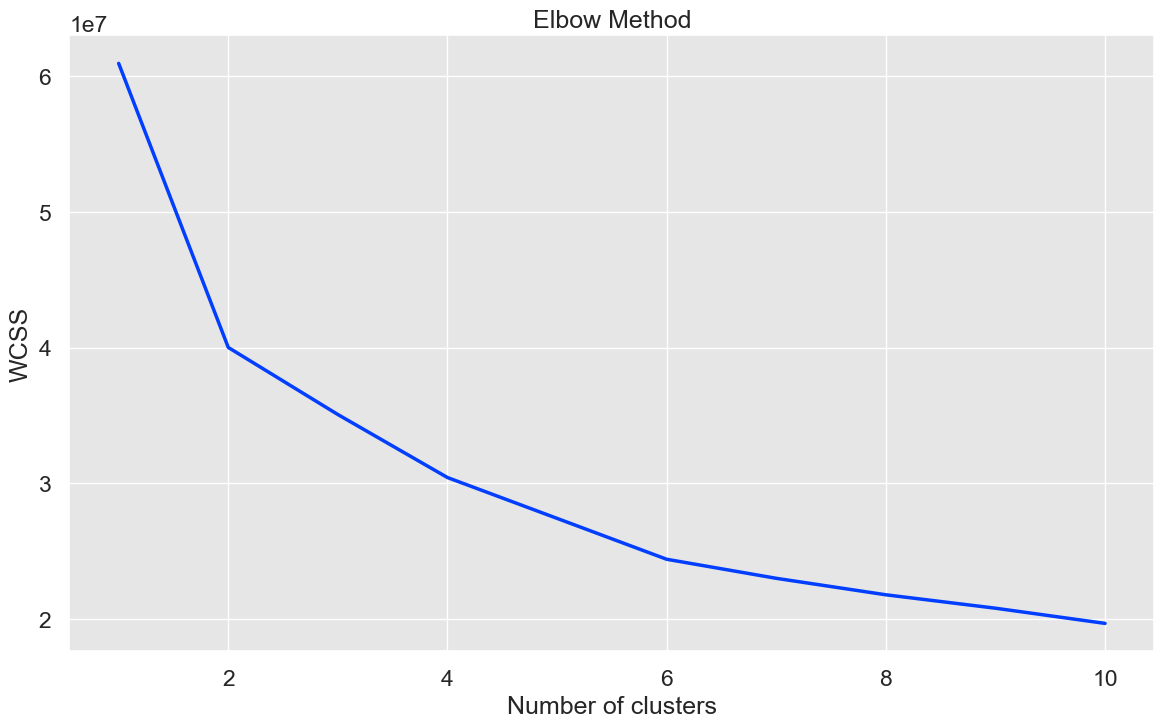

cluster sizes


,1,2,3,4,5,6,7,8,9,10
0,30928.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6781.0,24147.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,24269.0,3962.0,2697.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2216.0,18608.0,2547.0,7557.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3678.0,5822.0,2237.0,1821.0,17370.0,0.0,0.0,0.0,0.0,0.0
5,3672.0,347.0,5840.0,1825.0,17372.0,1872.0,0.0,0.0,0.0,0.0
6,4299.0,13807.0,1773.0,3444.0,1818.0,346.0,5441.0,0.0,0.0,0.0
7,2225.0,4109.0,4709.0,346.0,1748.0,13239.0,1158.0,3394.0,0.0,0.0
8,12409.0,1158.0,3273.0,346.0,4527.0,2145.0,1893.0,4042.0,1135.0,0.0
9,3690.0,4552.0,1109.0,1737.0,11093.0,2086.0,380.0,4392.0,345.0,1544.0


In [12]:
%run ./census_segmentation_helpers.py
Nrange=10
elbowmethod(X,Nrange)

**Silhouette Plot Demographics**

* Silhouette Plots Function is contained in the census_segmentation_helpers.py file
* https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
* Silhouette score of 
  * 1 indicates the point is far away from other cluster boundaries
  * 0 on a decision boundary with another cluster
  * < 0 indicates overlap with a decision boundary, perhaps the point is assigned to wrong cluster
  * Average Silhouette Score = red dotted line 

* 6 clusters seperates out the American Indian population (bottom right) - narrow yellow segment. Below is further discussion on the characteristics of each group which also factors in the cluster headtmap interpretation.

3.. 4.. 5.. 6.. 

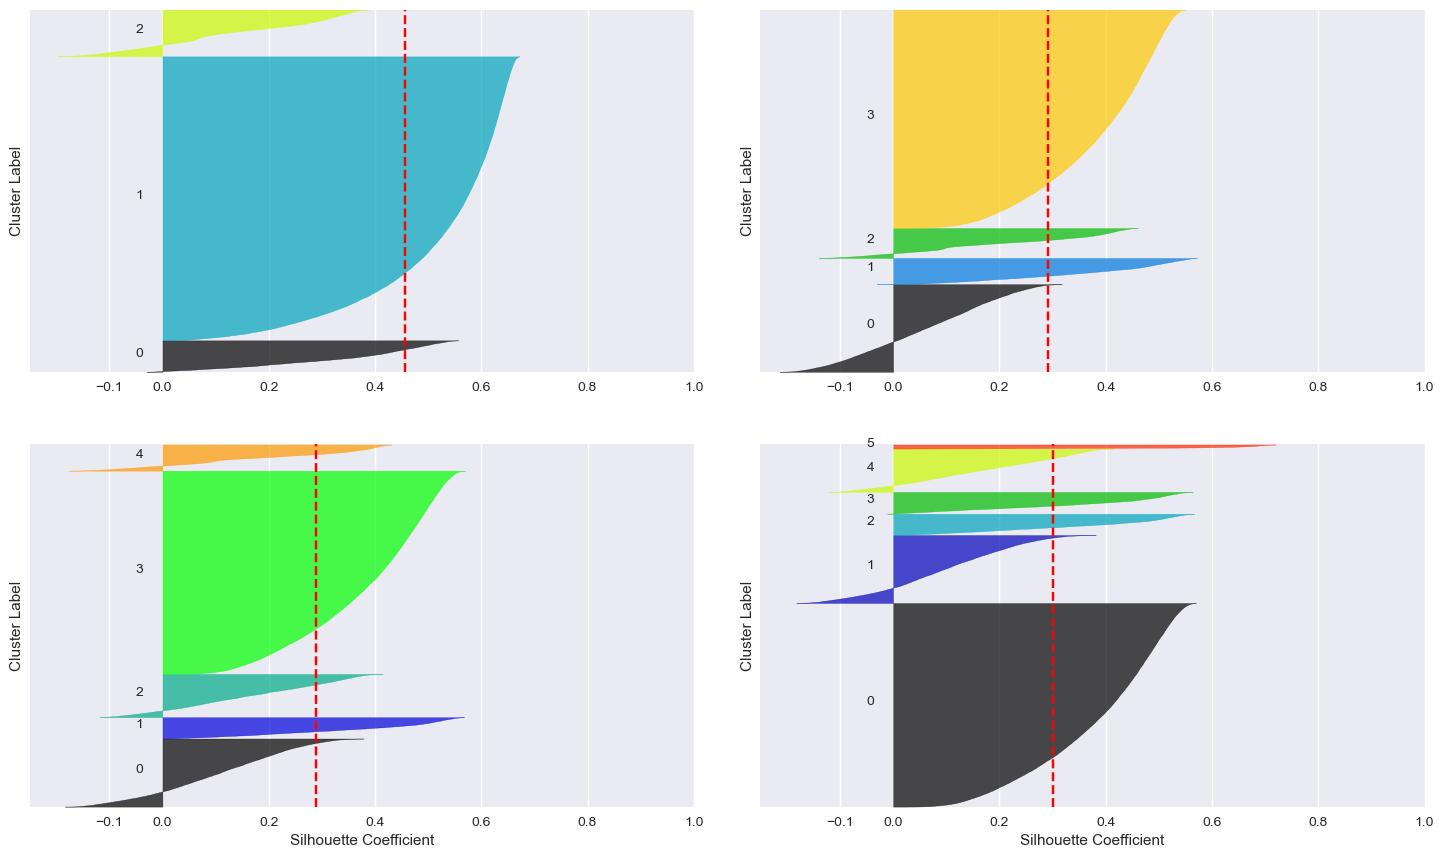

In [36]:
%run census_segmentation_helpers.py
silhouetteplots(X,range_n_clusters = [3, 4, 5, 6 ],figsize=(18,16))

### Choose N Clusters  = 6

In [14]:
clabels, centers, df_centers = KmeansCluster(X,6,verbose=1)


Cluster Label Counts:


Cluster Label,0,1,2,3,4,5
Count,17435,3688,1855,1805,347,5798


Cluster Centers

,24YAndUnderPercent,25To44YPercent,45To64YPercent,65YAndAbovePercent,WhitePercent,AfricanAmericanPercent,AmericanIndianAlaskaNativePercent,AsianPercent,NativeHawaiianPacificIslanderPercent,HispanicPercent,OtherNonHispanicPercent,HSGradOrHigherPercent,AssocDegPercent,BachDegPercent,GradOrProfDegPercent,UnEmpRate16YAO,UnEmpRate20to64Y,MedianEarnings16YAORel100K
0,28.093710,21.411107,29.903360,20.593492,92.986468,1.399433,0.608502,0.524510,0.039136,2.862194,1.579758,88.934689,9.939539,12.951069,6.463430,5.148245,4.828291,31.849645
1,28.098942,24.927421,29.398183,17.574071,79.521452,3.953255,0.260070,6.738253,0.068809,6.949447,2.508713,95.779899,7.479080,31.408397,23.498497,3.782777,3.555953,54.165980
2,36.287055,27.537163,23.567044,12.605771,23.862891,7.731991,0.672936,5.307712,0.211778,60.353897,1.858796,72.395849,6.554106,11.604449,5.499834,7.718932,7.212298,27.558559
3,32.821088,25.466537,26.393174,15.324528,29.187984,60.033139,0.391586,1.551812,0.041201,6.686728,2.107550,81.199811,7.512241,11.198378,6.604839,10.674362,10.034906,26.821691
4,41.908646,24.011239,23.139481,10.948127,10.373373,0.794501,81.257253,0.786362,0.169648,3.403356,3.215507,79.947307,6.619744,6.524931,3.609015,18.999424,19.071758,22.773640
5,34.455398,25.431545,24.934822,15.177906,62.725889,12.666922,1.897661,3.825472,0.302481,14.993306,3.588271,86.627184,8.527406,15.881570,8.918876,6.471076,5.937685,30.601645


In [15]:
clabels

array([0, 5, 5, ..., 5, 4, 5], dtype=int32)

###  Heatmap ZipCode Demographic Clusters

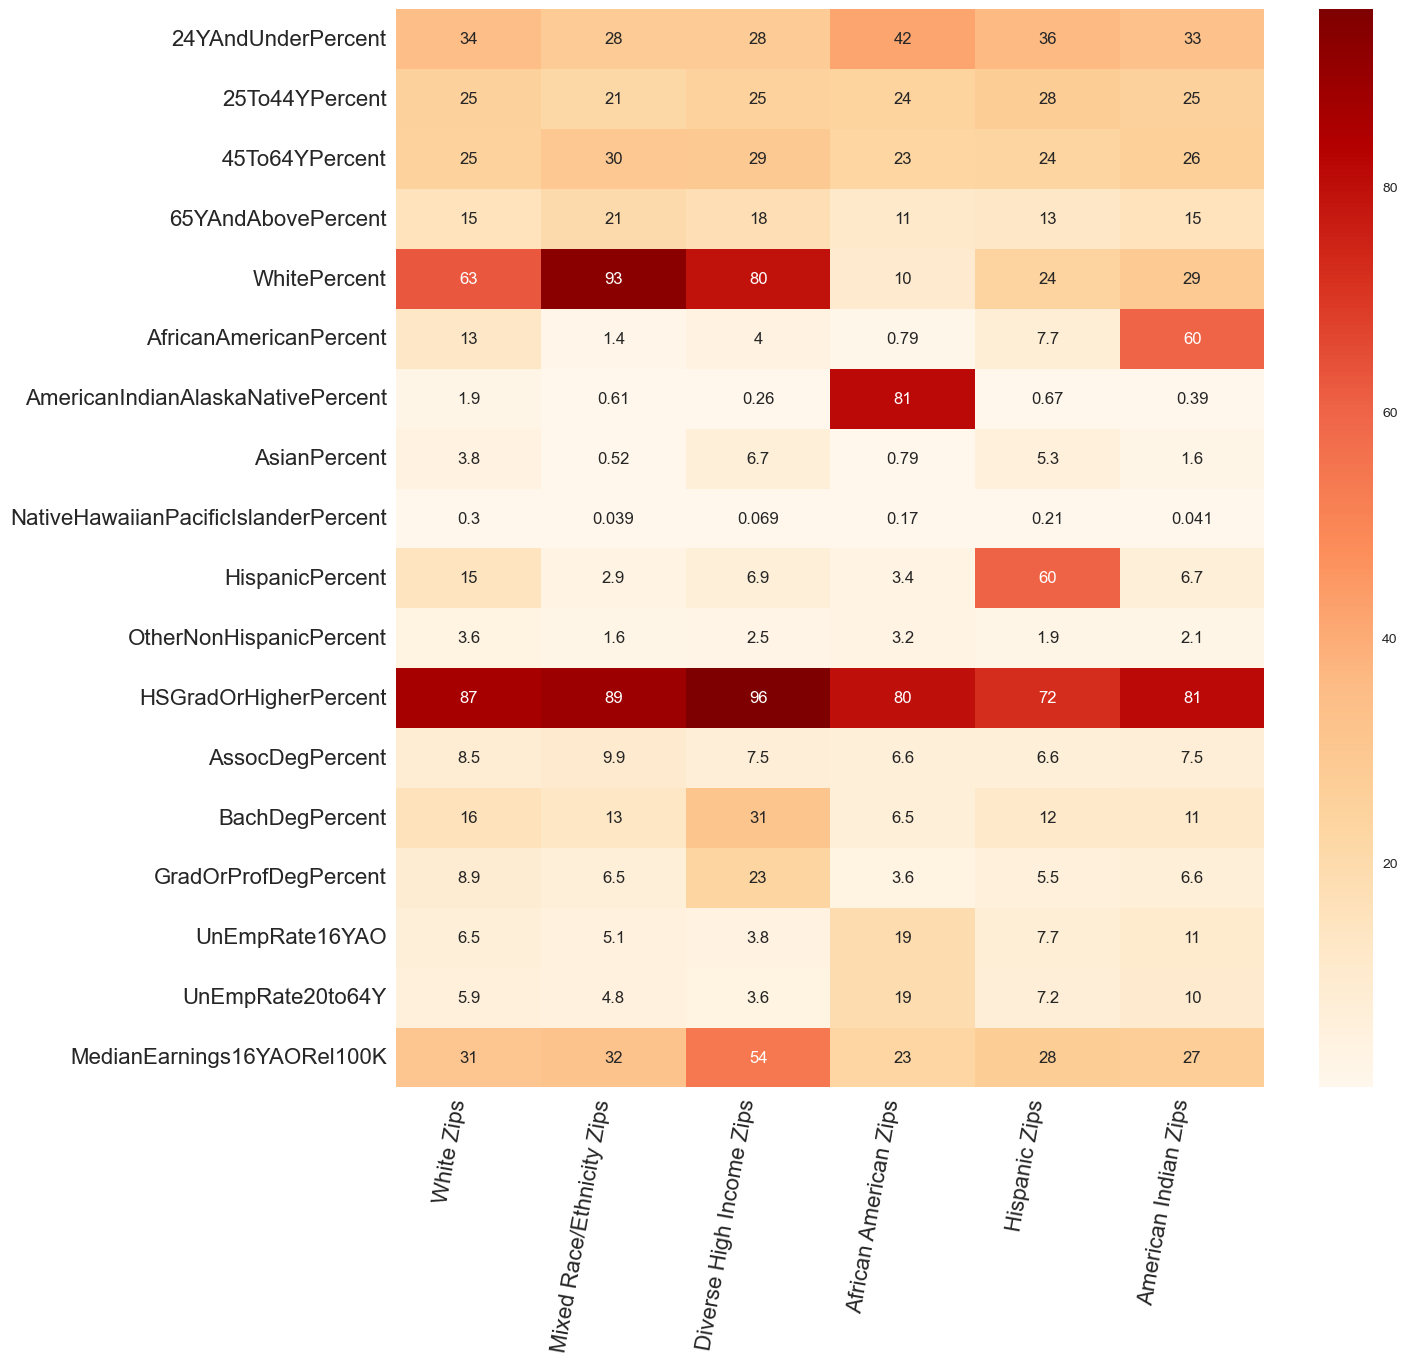

In [16]:
%run census_segmentation_helpers.py

df_heatmap = df_centers.copy().T
# first run without column names ... then get column names from interpretation below
# Note - a trick to automating the name-label assignments is to search for approx percentatages

demographic_labels = ['Mixed Race/Ethnicity Zips','Diverse High Income Zips', 'Hispanic Zips','American Indian Zips', 'African American Zips', 'White Zips']


df_heatmap.columns = demographic_labels

df_heatmap = df_heatmap[ ['White Zips' , 'Mixed Race/Ethnicity Zips','Diverse High Income Zips', 'African American Zips', 'Hispanic Zips','American Indian Zips']]
clusterheatmap(df_heatmap)

The clustering picked up on natural race ethnicity groups. The heatmap uses the centroid coordinates as the cluster prototype and is the basis for human interpretation. Recall that the raw data for each sample is reprents a ZipCode.


 * White - most homogeneous group with > 90% white
 * Mixed Race Ethnicity ... has best overall mix of races and ethnicity but earnings close to that of white
 * Diverse High Income - increased percentages races and ethnicities with highest income
 * African American - highest percentage of African American, 60%
 * Hispanic - highest percentage of Hispanic, 60%
 * American Indian - highest percentage of American Indian, 80%

Detailed evaluation of clusters to establishing the human interpretation
The cluster labels (i.e, cluster number, assigned labels) can potentially change between runs, so be careful to adjust accordingly.

* Cluster 5 - "Mostly White"
* Cluster 0 - "Mixed Race/Ethnicity"
* Cluster 1 - "DiverseHighIncomeHighEducation"
* Cluster 4 - "African American"
* Cluster 3 - "American Indian"
* Cluster 2 - "Hispanic"

#### Cluster 0 - "Mixed Race/Ethnicity"
  * 63% White
  * 13% African American
  * 3.8% Asian
  * 15% Hispanic
  * $31K Median Earnings
  
  
#### Cluster 1 - "DiverseHighIncomeHighEducation"
  * 80% White
  * 6.7% Asian
  * 6.9% Hispanic
  * 31% Bachelors
  * 23% Graduate
  * $54K Median Earnings
  
  
 #### Cluster 2 - "Hispanic"
  * 24% Whte percent
  * 5.3% Asian
  * 60% Hispanic
  * 72% HS Grad
  * 12% Bachelors
  * 5.5% Graduate
  * $28K Median Earnings
  
#### Cluster 3 - "American Indian"
  * 10% White
  * 81% American India Alaska Native ... see below, lower 48 mainland geo locations American Indian
  * 3.4% Hispanic
  * HS Grad 80%
  * Bachers 6.5%
  * Graduate 3.6%
  * $23K Median Earnings
  
#### Cluster 4 - "African American"
  * 29% White
  * 60% African American
  * 6.7% Hispanic
  * 11% Bachelors
  * 6.6% Graduate
  * $27K Median Earnings

####  Cluster 5 - "White"
 * 93% White 
 * 2.9% Hispanic
 * 1.4% African American
 * 13 % Bachelors Degree
 * 6.5 % Graduate education
 * $32K Median Earnings (16 Year olds and over)




In [17]:
print(X.shape)
print(X.columns)

(30928, 18)
Index(['24YAndUnderPercent', '25To44YPercent', '45To64YPercent',
       '65YAndAbovePercent', 'WhitePercent', 'AfricanAmericanPercent',
       'AmericanIndianAlaskaNativePercent', 'AsianPercent',
       'NativeHawaiianPacificIslanderPercent', 'HispanicPercent',
       'OtherNonHispanicPercent', 'HSGradOrHigherPercent', 'AssocDegPercent',
       'BachDegPercent', 'GradOrProfDegPercent', 'UnEmpRate16YAO',
       'UnEmpRate20to64Y', 'MedianEarnings16YAORel100K'],
      dtype='object')


# Population and Earnings by ZipCode Categories

In [18]:
X.head()

,24YAndUnderPercent,25To44YPercent,45To64YPercent,65YAndAbovePercent,WhitePercent,AfricanAmericanPercent,AmericanIndianAlaskaNativePercent,AsianPercent,NativeHawaiianPacificIslanderPercent,HispanicPercent,OtherNonHispanicPercent,HSGradOrHigherPercent,AssocDegPercent,BachDegPercent,GradOrProfDegPercent,UnEmpRate16YAO,UnEmpRate20to64Y,MedianEarnings16YAORel100K
0,23.3,25.2,27.3,24.1,88.349129,1.963566,0.034050,2.514046,0.000000,5.521821,1.617388,91.479123,8.757773,19.255256,13.244004,3.4,3.8,41.829
1,54.0,17.6,16.6,11.8,71.339719,5.946917,0.179605,10.886051,0.113085,7.337192,4.197432,95.164899,5.614491,25.553872,41.459190,5.9,5.0,13.185
2,98.9,0.7,0.4,0.0,70.492970,4.778430,0.462716,16.221748,0.000000,5.552589,2.491547,77.118644,8.474576,11.016949,4.237288,18.4,12.7,4.148
3,28.5,16.9,39.1,15.3,94.470046,2.304147,0.000000,0.781407,0.000000,1.242236,1.202164,96.133371,10.170916,17.231718,15.130289,5.9,6.1,38.254
4,32.4,19.3,33.6,14.7,93.338678,0.567916,0.000000,3.313957,0.000000,1.389724,1.389724,94.733202,9.278656,24.426877,23.379447,4.0,3.4,47.755


,ZipCode,24YAndUnderPercent,25To44YPercent,45To64YPercent,65YAndAbovePercent,WhitePercent,AfricanAmericanPercent,AmericanIndianAlaskaNativePercent,AsianPercent,NativeHawaiianPacificIslanderPercent,HispanicPercent,OtherNonHispanicPercent,HSGradOrHigherPercent,AssocDegPercent,BachDegPercent,GradOrProfDegPercent,UnEmpRate16YAO,UnEmpRate20to64Y,MedianEarnings16YAORel100K,clabel,TotalPopulation.popagesex,Pop25YAO.edattain,AssocDeg25YAO,HSGrad25YAO,BachDeg25YAO,GradOrProfDeg25YAO,HSGradOrHigher25YAO,MedianEarnings16YAO
0,01001,23.3,25.2,27.3,24.1,88.349129,1.963566,0.034050,2.514046,0.000000,5.521821,1.617388,91.479123,8.757773,19.255256,13.244004,3.4,3.8,41.829,0,17621,13508,1183,3816,2601,1789,12357,41829.0
1,01002,54.0,17.6,16.6,11.8,71.339719,5.946917,0.179605,10.886051,0.113085,7.337192,4.197432,95.164899,5.614491,25.553872,41.459190,5.9,5.0,13.185,5,30066,13857,778,1860,3541,5745,13187,13185.0
2,01003,98.9,0.7,0.4,0.0,70.492970,4.778430,0.462716,16.221748,0.000000,5.552589,2.491547,77.118644,8.474576,11.016949,4.237288,18.4,12.7,4.148,5,11238,118,10,14,13,5,91,4148.0
3,01005,28.5,16.9,39.1,15.3,94.470046,2.304147,0.000000,0.781407,0.000000,1.242236,1.202164,96.133371,10.170916,17.231718,15.130289,5.9,6.1,38.254,0,4991,3569,363,1315,615,540,3431,38254.0
4,01007,32.4,19.3,33.6,14.7,93.338678,0.567916,0.000000,3.313957,0.000000,1.389724,1.389724,94.733202,9.278656,24.426877,23.379447,4.0,3.4,47.755,1,14967,10120,939,2259,2472,2366,9587,47755.0


,TotalPopulationMil,Pop25YAOMil,HSGradPercent,AssocPercent,BachPercent,GradProfPercent
Mixed Race/Ethnicity Zips,80.721966,56.804759,0.344224,0.098367,0.152858,0.083494
Diverse High Income Zips,65.862965,46.441553,0.156712,0.073097,0.319135,0.239260
Hispanic Zips,50.067837,31.667262,0.274558,0.069881,0.135008,0.064096
American Indian Zips,28.842057,18.977869,0.312747,0.076693,0.140874,0.085662
African American Zips,0.639905,0.374171,0.356965,0.080439,0.075468,0.038889
White Zips,96.274905,63.842717,0.274855,0.088235,0.187244,0.107276


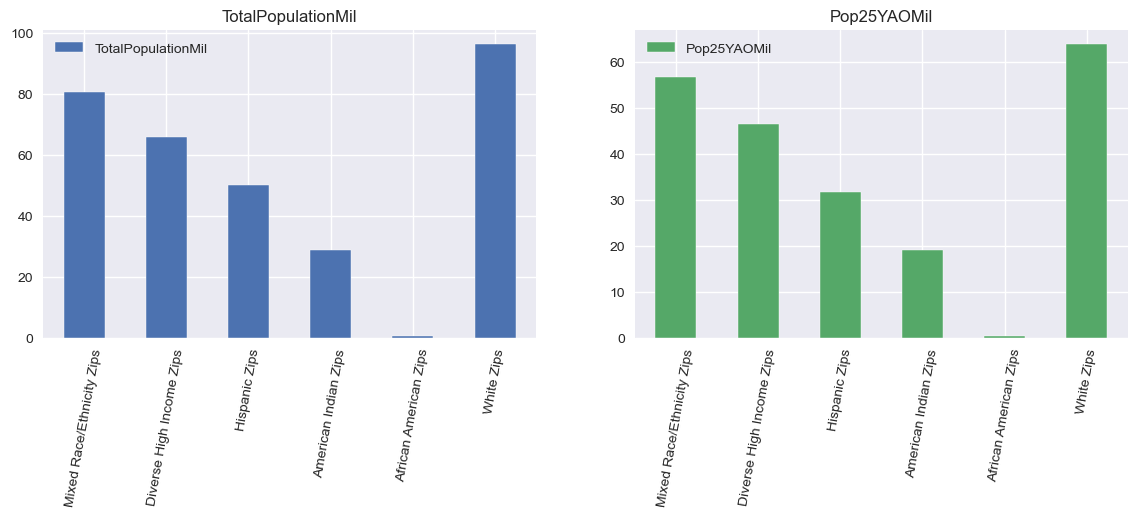

,clabel,TotalPopulation,Pop25YAO,AssocDeg25YAO,HSGrad25YAO,BachDeg25YAO,GradOrProfDeg25YAO,HSGradOrHigher25YAO,AvgMedianEarnings16YAO,HSGradPercent,AssocPercent,BachPercent,GradProfPercent,HSGradOrHigherPercent,TotalPopulationMil,Pop25YAOMil
Mixed Race/Ethnicity Zips,0,80721966,56804759,5587742,19553563,8683045,4742837,51016752,31848.447720,0.344224,0.098367,0.152858,0.083494,0.898107,80.721966,56.804759
Diverse High Income Zips,1,65862965,46441553,3394760,7277953,14821120,11111629,44350216,54165.638829,0.156712,0.073097,0.319135,0.239260,0.954968,65.862965,46.441553
Hispanic Zips,2,50067837,31667262,2212955,8694496,4275321,2029729,23433933,27561.022642,0.274558,0.069881,0.135008,0.064096,0.740005,50.067837,31.667262
American Indian Zips,3,28842057,18977869,1455473,5935276,2673490,1625682,15900609,26830.690859,0.312747,0.076693,0.140874,0.085662,0.837850,28.842057,18.977869
African American Zips,4,639905,374171,30098,133566,28238,14551,295450,22773.639769,0.356965,0.080439,0.075468,0.038889,0.789612,0.639905,0.374171
White Zips,5,96274905,63842717,5633131,17547476,11954140,6848776,56223354,30601.365298,0.274855,0.088235,0.187244,0.107276,0.880654,96.274905,63.842717


In [19]:
# Earnings by Education

#from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_samples, silhouette_score




myaggs = { 'TotalPopulation.popagesex' : 'sum' , 
          'Pop25YAO.edattain' : 'sum' , 
          'AssocDeg25YAO': 'sum',
           'HSGrad25YAO' : 'sum' ,   
          'BachDeg25YAO' : 'sum',  
          'GradOrProfDeg25YAO' : 'sum',  
          'HSGradOrHigher25YAO':'sum'  ,
          'MedianEarnings16YAO' : 'mean'}

dfag=X.copy()
dfag['clabel']=clabels  # put cluster labels into the dataframe
dfag['ZipCode']=pd.DataFrame(XZ['ZipCode']) # add zip codes to dataframe

group_cols=['TotalPopulation.popagesex', 'Pop25YAO.edattain',
            'AssocDeg25YAO','HSGrad25YAO','BachDeg25YAO',
           'GradOrProfDeg25YAO' , 'HSGradOrHigher25YAO','MedianEarnings16YAO']

# join population columns by zip code
dfag=dfag.set_index('ZipCode').join(df[['ZipCode']+group_cols].set_index('ZipCode')).reset_index()
display(dfag.head(5))

# aggrate 
dfag=dfag[['clabel']+group_cols].groupby('clabel').agg(myaggs).reset_index()



#Mixed Race Ethnicity ... has best overall mix of races and ethnicity but earnings close to that of white
#Diverse High Income - increased percentages races and ethnicities with highest income
#African American - highest percentage of African American, 60%
#Hispanic - highest percentage of Hispanic, 60%
#American Indian - highest percentage of American Indian, 80%
#White - most homogeneous group with > 90% white

dfag.index = ['Mixed Race/Ethnicity Zips','Diverse High Income Zips','Hispanic Zips','American Indian Zips','African American Zips', 'White Zips']

# these are interesting for comparison to cluster centers above
dfag['HSGradPercent']=dfag['HSGrad25YAO']/dfag['Pop25YAO.edattain']
dfag['AssocPercent']=dfag['AssocDeg25YAO']/dfag['Pop25YAO.edattain']
dfag['BachPercent']=dfag['BachDeg25YAO']/dfag['Pop25YAO.edattain']
dfag['GradProfPercent']=dfag['GradOrProfDeg25YAO']/dfag['Pop25YAO.edattain']
dfag['HSGradOrHigherPercent']=dfag['HSGradOrHigher25YAO']/dfag['Pop25YAO.edattain']

# populations in millions

dfag['TotalPopulationMil']=dfag['TotalPopulation.popagesex']/1000000
dfag['Pop25YAOMil']=dfag['Pop25YAO.edattain']/1000000

dfag.rename(columns={'MedianEarnings16YAO': 'AvgMedianEarnings16YAO', 
                     'TotalPopulation.popagesex' : 'TotalPopulation',
                     'Pop25YAO.edattain': 'Pop25YAO'},inplace=True)




display(dfag[['TotalPopulationMil','Pop25YAOMil','HSGradPercent','AssocPercent','BachPercent','GradProfPercent']])



plt_style='seaborn'
matplotlib.style.use(plt_style)

graph_cols=['TotalPopulationMil','Pop25YAOMil']
dfag[graph_cols].plot(kind='bar', subplots=True, figsize=[14,4], layout=(1,2), rot=80)

plt.show()
dfag


array([[<AxesSubplot:title={'center':'AvgMedianEarnings16YAO'}>,
        <AxesSubplot:>]], dtype=object)

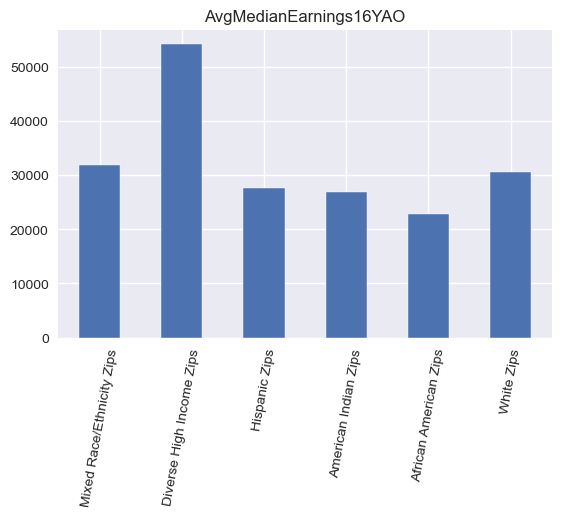

In [20]:
dfag['AvgMedianEarnings16YAO'].plot(kind='bar', subplots=True, figsize=[14,4], layout=(1,2), rot=80)

# ZipCode Clusters by Industry

In [21]:
# cluster columns
#  later will seperate out zip code

#Industry Column Names
cluster_cols2=['ZipCode','AggFarmFishMingPercent','ConstructionPercent','ManufacturingPercent', 
         'WholesaleTradePercent','EducationHealthcareSocialPercent',
         'RetailTradePercent','TransportationWarehouseUtilitiesPercent','ArtsEntertainmentRecAccomFoodPercent',
         'OtherPercent','InformationPercent','FinanceInsuranceRealestateRentalPercent','PublicAdminPercent'] 

# Alternatively could use Occupation and Industry Column Names ... 
cluster_cols_tmp=['ZipCode','AggFarmFishMingPercent','ConstructionPercent','ManufacturingPercent', 
         'WholesaleTradePercent','EducationHealthcareSocialPercent',
         'RetailTradePercent','TransportationWarehouseUtilitiesPercent','ArtsEntertainmentRecAccomFoodPercent',
         'OtherPercent','InformationPercent','FinanceInsuranceRealestateRentalPercent','PublicAdminPercent',
        'MBSA_ManagementBusFinPercent','MBSA_ComputerEngineeringSciencePercent','MBSA_EduLegalComServiceArtsMediaPercent',
          'MBSA_HealthcarePractionerAndTechnicalPercent','ServicePercent','SalesAndOfficePercent',
          'NCS_FarmingFishingForestryPercent','NCS_InstallationMaintenanceRepairPercent','NCS_ConstructionExtractionPercent',
          'ProductionTransportationMaterialMovingPercent' ] 

print('df shape',df.shape)

X2 = df[cluster_cols2]

# Count NaNs
dfna=df[df.isna().any(axis=1)]
X2na=X2[X2.isna().any(axis=1)]
print('X2na.shape = ',X2na.shape)
print('dfna.shape = ',dfna.shape)

# Drop NaNs
XZ2=X2.dropna()
print('XZ2 shape =',XZ2.shape)

# Remove ZipCode from Y
# Zipcode contained in YZ
Z2=XZ2['ZipCode'].copy()
X2=XZ2.drop(columns='ZipCode').copy()

print('')
print('Z2.head(3):')
display(Z2.head(3))
print('X.describe:')
X2.describe()

#Y2.describe()


df shape (32989, 63)
X2na.shape =  (758, 13)
dfna.shape =  (11928, 63)
XZ2 shape = (32231, 13)

Z2.head(3):


0    01001
1    01002
2    01003
Name: ZipCode, dtype: object

X.describe:


,AggFarmFishMingPercent,ConstructionPercent,ManufacturingPercent,WholesaleTradePercent,EducationHealthcareSocialPercent,RetailTradePercent,TransportationWarehouseUtilitiesPercent,ArtsEntertainmentRecAccomFoodPercent,OtherPercent,InformationPercent,FinanceInsuranceRealestateRentalPercent,PublicAdminPercent
count,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000,32231.000000
mean,6.690016,8.018918,14.193492,2.889712,21.313235,9.348588,6.302996,5.615268,3.988408,1.555358,5.670405,6.329119
std,11.888696,7.755304,11.625850,3.731420,11.269153,7.724110,6.617187,7.687991,4.871966,2.903892,5.845681,7.590214
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.182239,3.973510,6.098038,0.488718,15.763204,5.773957,2.944187,1.477905,1.598634,0.000000,2.054795,2.393050
50%,1.992032,6.769231,12.138320,2.358491,20.646255,8.822398,5.272565,4.151625,3.477345,0.944206,4.830918,4.653974
75%,7.884862,10.192167,19.942424,3.928268,25.875692,11.557115,8.038839,7.055737,5.111767,2.179441,7.813440,7.857009
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


1.. 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 

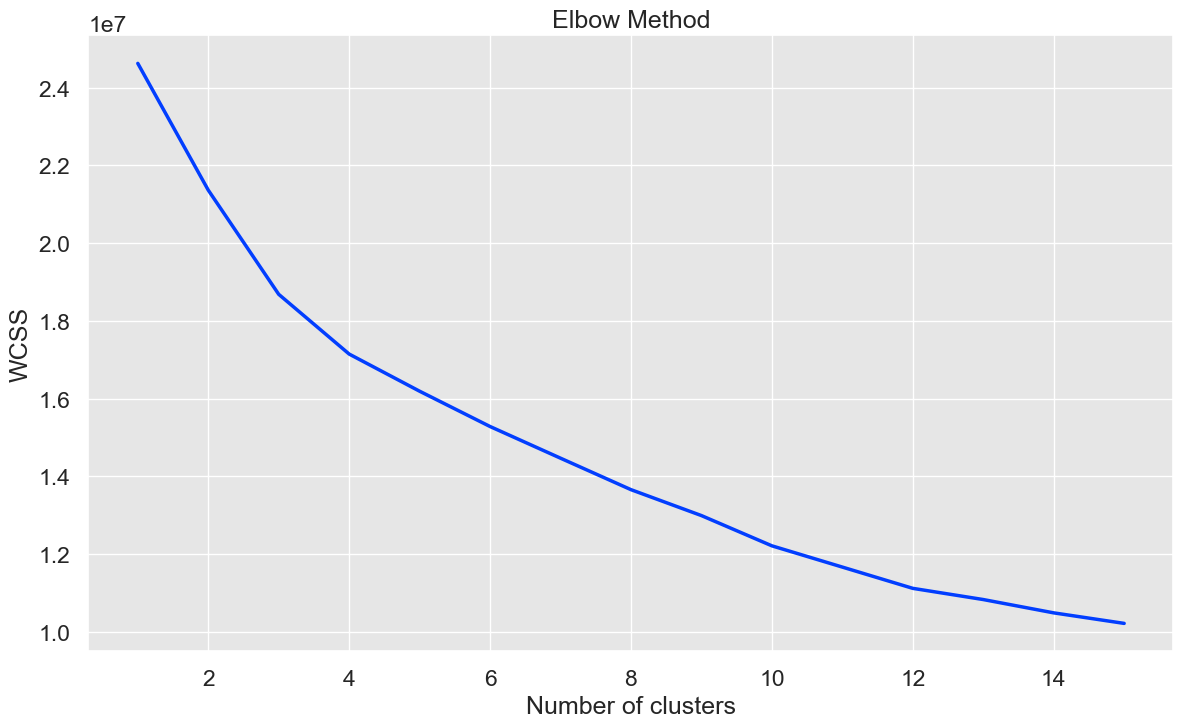

cluster sizes


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,32231.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,29437.0,2794.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2472.0,9044.0,20715.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8208.0,2341.0,18295.0,3387.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3914.0,17342.0,1514.0,7215.0,2246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,19097.0,7478.0,1856.0,710.0,2260.0,830.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,16890.0,4213.0,7080.0,857.0,1682.0,809.0,700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,794.0,3827.0,17214.0,7025.0,322.0,704.0,1660.0,685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3786.0,691.0,1487.0,1846.0,13368.0,9376.0,310.0,707.0,660.0,0.0,0.0,0.0,0.0,0.0,0.0
9,635.0,13321.0,1836.0,703.0,9386.0,1310.0,3618.0,672.0,462.0,288.0,0.0,0.0,0.0,0.0,0.0


In [22]:
Nrange=15
elbowmethod(X2,Nrange)

3.. 4.. 5.. 6.. 

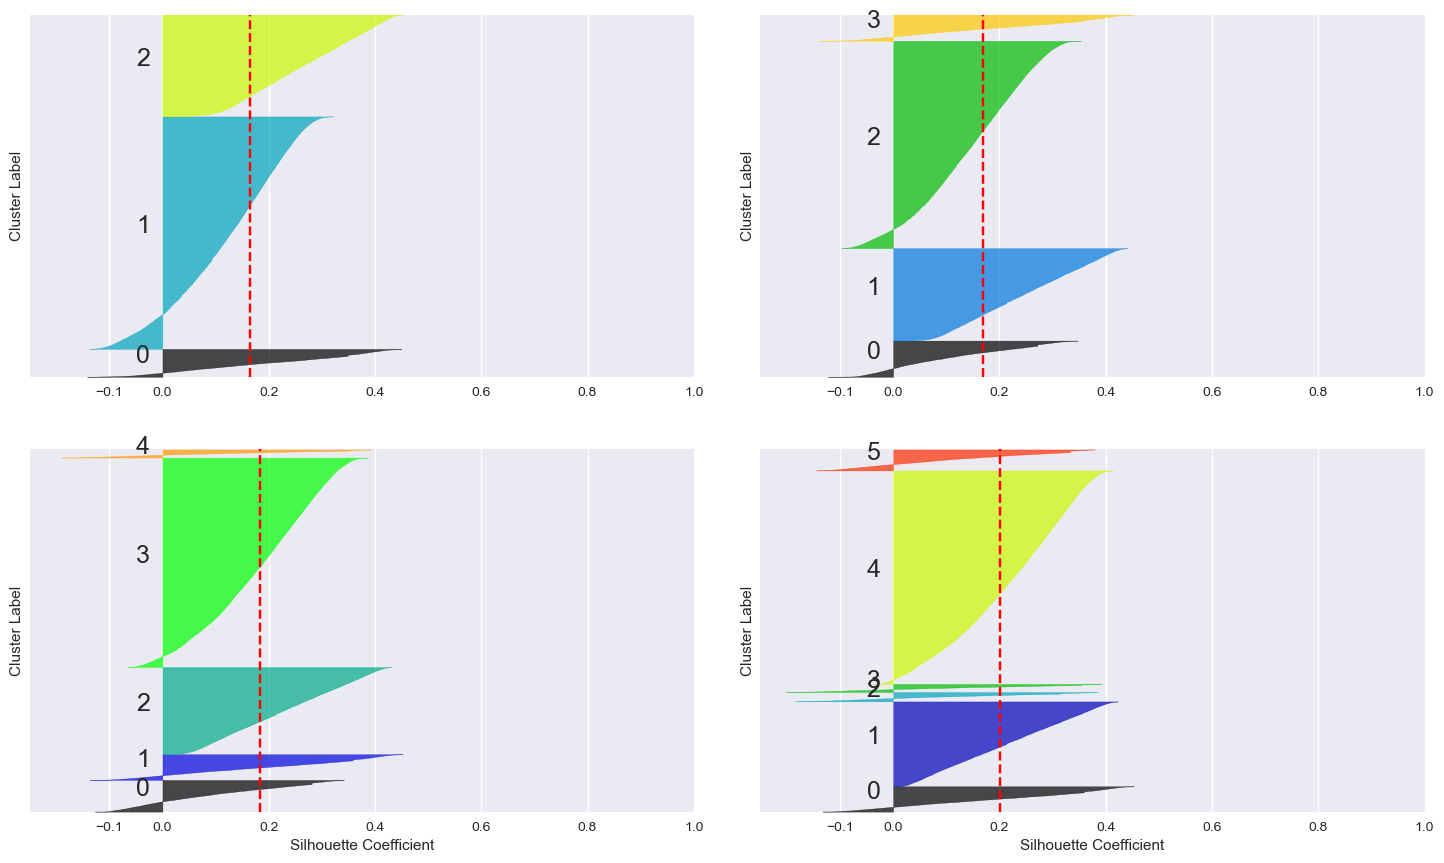

In [23]:
%run census_segmentation_helpers.py
silhouetteplots(X2,range_n_clusters = [3, 4, 5, 6 ],figsize=(18,16))

In [27]:

%run census_segmentation_helpers.py

clabels2, centers2, df_centers2 = KmeansCluster(X2,4,verbose=0)

df_centers2.head()

,AggFarmFishMingPercent,ConstructionPercent,ManufacturingPercent,WholesaleTradePercent,EducationHealthcareSocialPercent,RetailTradePercent,TransportationWarehouseUtilitiesPercent,ArtsEntertainmentRecAccomFoodPercent,OtherPercent,InformationPercent,FinanceInsuranceRealestateRentalPercent,PublicAdminPercent
0,3.744090,8.786620,9.803186,3.046019,20.051942,10.485436,6.702833,6.919376,4.380073,1.882593,6.925658,7.329538
1,40.285158,6.506700,6.001097,2.908016,13.615838,6.326128,5.857330,3.443943,2.949881,0.780661,3.039853,4.705999
2,4.260710,6.063968,7.050487,2.034971,43.406483,6.838114,4.691091,4.528153,3.377766,1.269082,3.882483,6.426120
3,4.761034,7.437778,29.324698,2.852364,17.975379,8.565254,6.129080,3.662036,3.620724,1.136123,4.227893,4.463334


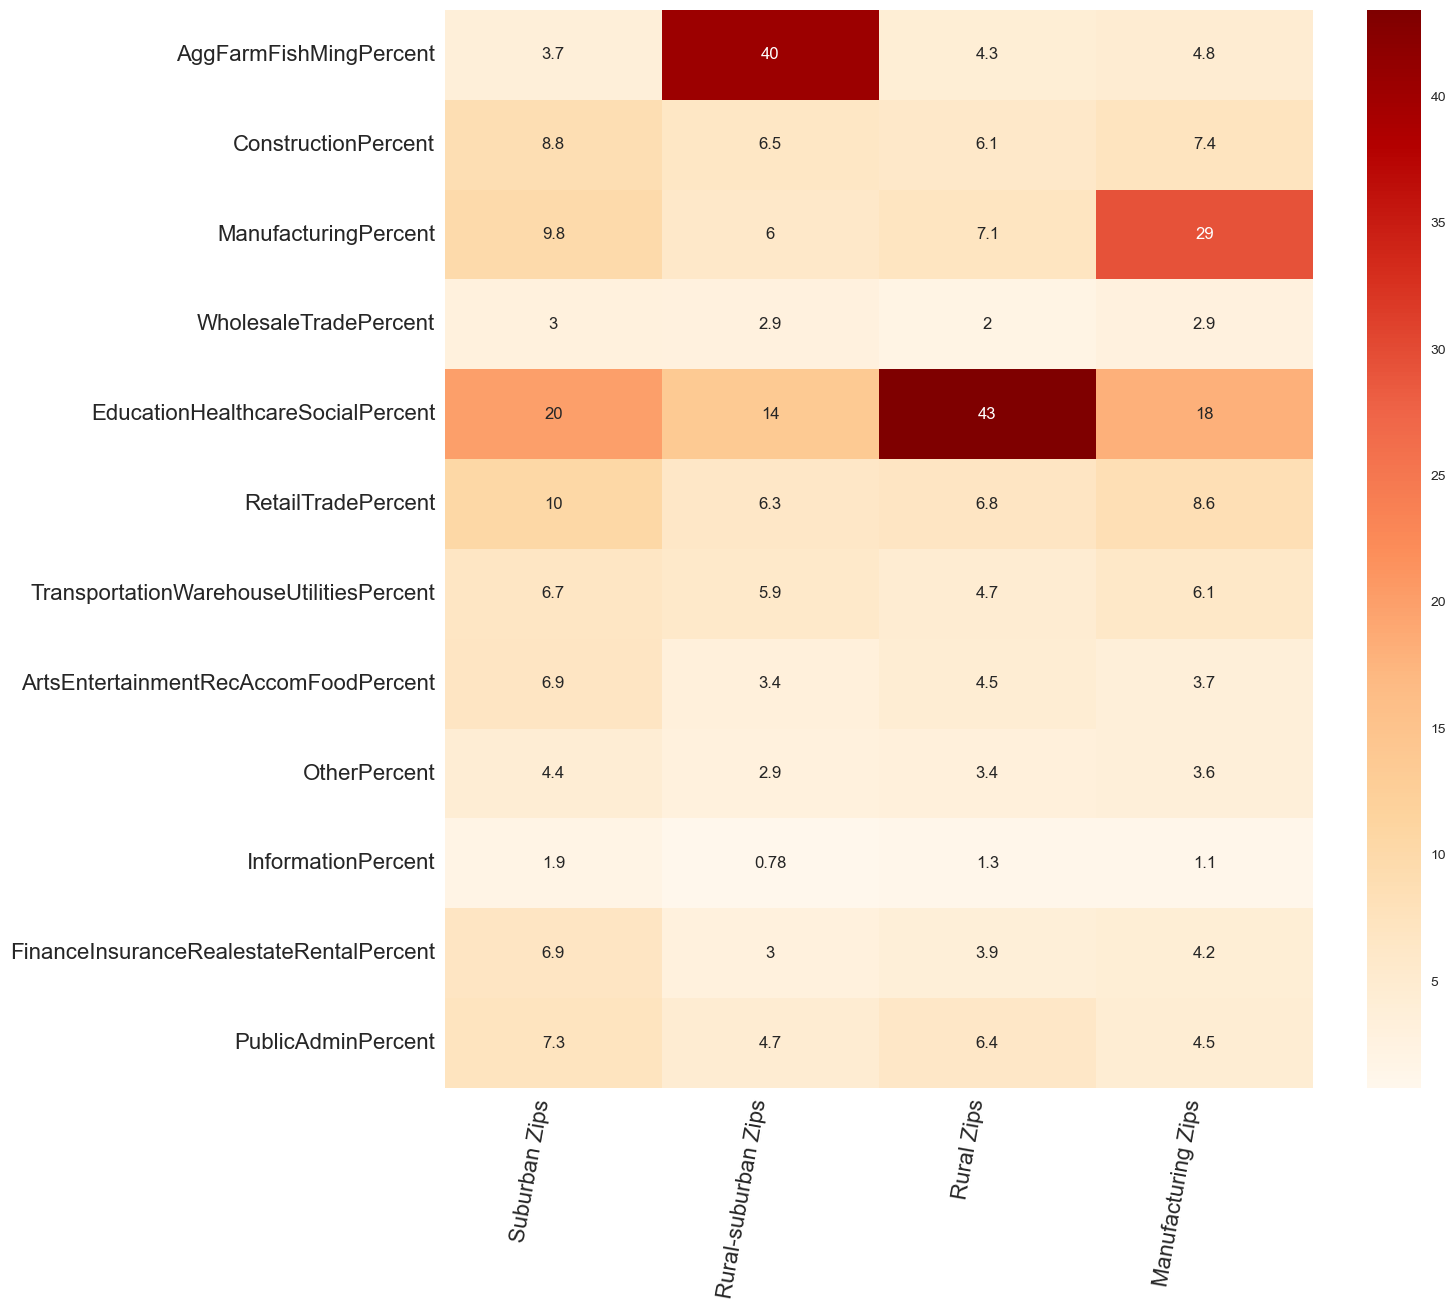

In [28]:

%run census_segmentation_helpers.py

df_heatmap2 = df_centers2.copy().T
# first run without column names ... then get column names from interpretation below
# Note - a trick to automating the name-label assignments is to set logic, approx percentatages

industry_labels =  ['Suburban Zips','Rural-suburban Zips', 'Rural Zips','Manufacturing Zips']


df_heatmap2.columns = industry_labels

matplotlib.style.use('ggplot')
clusterheatmap(df_heatmap2)
plt.show()


### Number of clusters
* There is no obvious choice for number of clusters. The "Elbow Curve" shows a smooth transition, not a elbow true effect.  Observing the Silhouette charts and also analyzing heatmap, 4 clusters is chosen. This shows 4 clear dominant cluster. The clusters Manufacturng, Aggriculture, and Education Healthcare, clearly show dominant charisterics. 


### Interpretation
* **Suburban**, Education Healthcare Social with some Industry (cluster 0) -  There is dominant Education Healthcare Social and consistently more industry in this cluster than the next cluster (cluster 1). This cluster is the largest in size (number of zips based on the corresponding Silhouette chart (above).  It is most likely a suburb with schools, retail and light industry. 

* **Rurual-suburban**, Education Healtchare Social Zips (Cluster 1) - Education Healthcare Social Zips. This cluster has light industry and dominant Education Healthcare Social, and slightly more agrigulture and farming - sounds like rural-suburbs. 

* **Aggriculture Farming Fishing Zips** (Cluster 2) - Dominant Agriculture Farming Fishing, sounds like rural Zip Codes. 

* **Manufacturing** (Cluster 3) -  Dominant Manufactring with sub-dominant Education Healthcare and Social.



# Geo Map ZipCode Demographics (Race Ethnicity, Education, Income)

### Prepare data

Load zip city state lat long  
Join zip rows with zip lat longs


 ./data_census/zipcitystatelatlong.csv


,ZipCode,City,State,Latitude,Longitude
0,71937,Cove,AR,34.398483,-94.39398
1,72044,Edgemont,AR,35.624351,-92.16056
2,56171,Sherburn,MN,43.660847,-94.74357


,ZipCode,24YAndUnderPercent,25To44YPercent,45To64YPercent,65YAndAbovePercent,WhitePercent,AfricanAmericanPercent,AmericanIndianAlaskaNativePercent,AsianPercent,NativeHawaiianPacificIslanderPercent,HispanicPercent,OtherNonHispanicPercent,HSGradOrHigherPercent,AssocDegPercent,BachDegPercent,GradOrProfDegPercent,UnEmpRate16YAO,UnEmpRate20to64Y,MedianEarnings16YAORel100K,clabel,City,State,Latitude,Longitude
0,01001,23.3,25.2,27.3,24.1,88.349129,1.963566,0.034050,2.514046,0.000000,5.521821,1.617388,91.479123,8.757773,19.255256,13.244004,3.4,3.8,41.829,0,Agawam,MA,42.070610,-72.62029
1,01002,54.0,17.6,16.6,11.8,71.339719,5.946917,0.179605,10.886051,0.113085,7.337192,4.197432,95.164899,5.614491,25.553872,41.459190,5.9,5.0,13.185,5,Amherst,MA,42.377651,-72.50323
2,01003,98.9,0.7,0.4,0.0,70.492970,4.778430,0.462716,16.221748,0.000000,5.552589,2.491547,77.118644,8.474576,11.016949,4.237288,18.4,12.7,4.148,5,Amherst,MA,42.369562,-72.63599


Mixed Race/Ethnicity Zips    17435
Diverse High Income Zips      3688
Hispanic Zips                 1855
American Indian Zips          1805
African American Zips          347
Name: ZipCode, dtype: int64

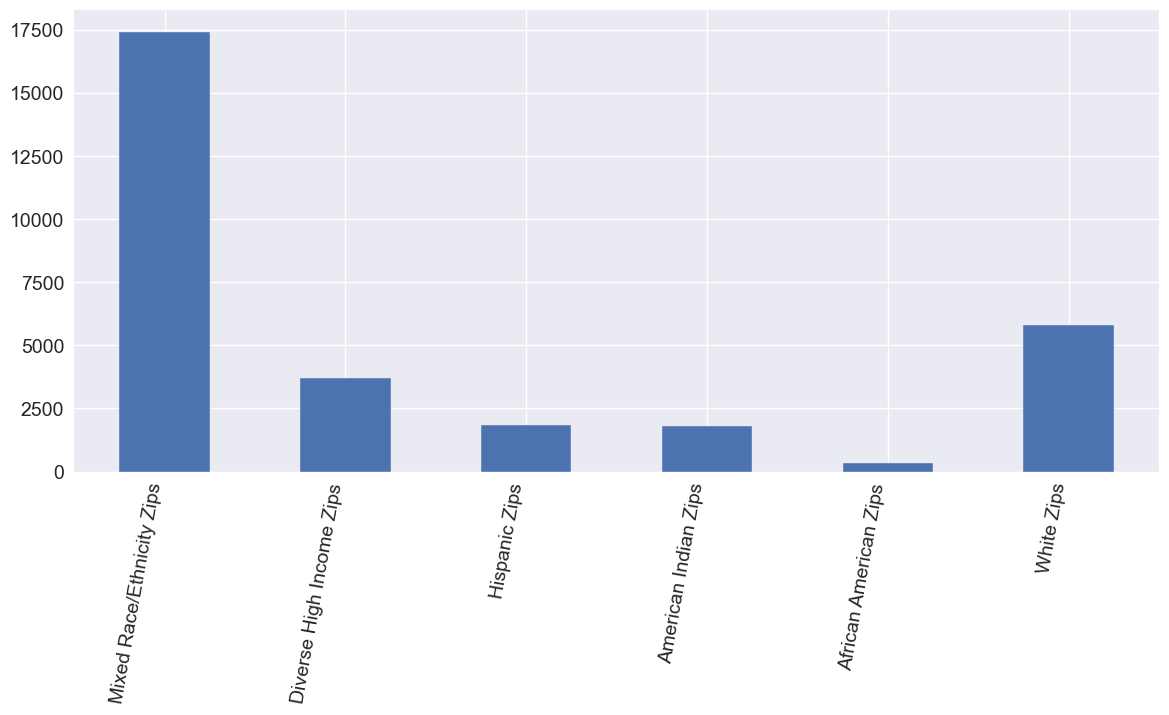

In [30]:
# Data Prep for Geo Maps
#   XZL row information, with Zip Code, and Cluster Labels
#   XZLLL row information, with Zip Code, Cluster Labels, Lats, and Longs
XZL = XZ.copy()


XZL['clabel']=clabels


# Load Zip City State Lat Long 
read_filename='./data_census/zipcitystatelatlong.csv'
print('\n', read_filename)
df_zipcitystatelatlong= pd.read_csv(read_filename, dtype={'ZipCode': str})
display(df_zipcitystatelatlong.head(3))

# join  zips infor with zip lat long
XZLLL=XZL.set_index('ZipCode').join(df_zipcitystatelatlong.set_index('ZipCode')).reset_index()

display(XZLLL.head(3))



XZ_label_count=XZLLL.groupby('clabel')['ZipCode'].count()
XZ_label_count.index  = demographic_labels
display(XZ_label_count.head())


matplotlib.style.use('seaborn')
g=XZ_label_count.plot(kind='bar', rot = 80, figsize=[14,6])
g = XZ_label_count.plot(kind='bar', figsize=[14,6])
g.set_xticklabels(g.get_xticklabels(), rotation=80, horizontalalignment='right', size=14)
plt.yticks(fontsize=14)
plt.show()



## Discussion Zip Code Demographic Geo Plots
* It is satisfying to see that the clustering algorithm picks up on geographic realities 
* Chart 1 shows the White zip codes well represented across the states
* Chart 2 illustrates mixed and diverse high income not as dense but clearly represented across the states. 
* Chart 3 shows the African American zip codes concentrated in the South and in the North East. It is also interesting that there are a few zip codes in California (San Francisco, Oakland, Los Angeles), New Mexico, Oaklahoma, however most of the west does not contain African American zip codes.
* Chart 4 illustrates the Hispanic and African American zip codes. THe Hispanic zip codes are concentrated in California, Washington (state), Arizona, New Mexico, Texas, Florida, and in the North East. Indian zip codes show high concentration in Northern Arizona, New Mexico, and other isolated pockets (likely reservations).




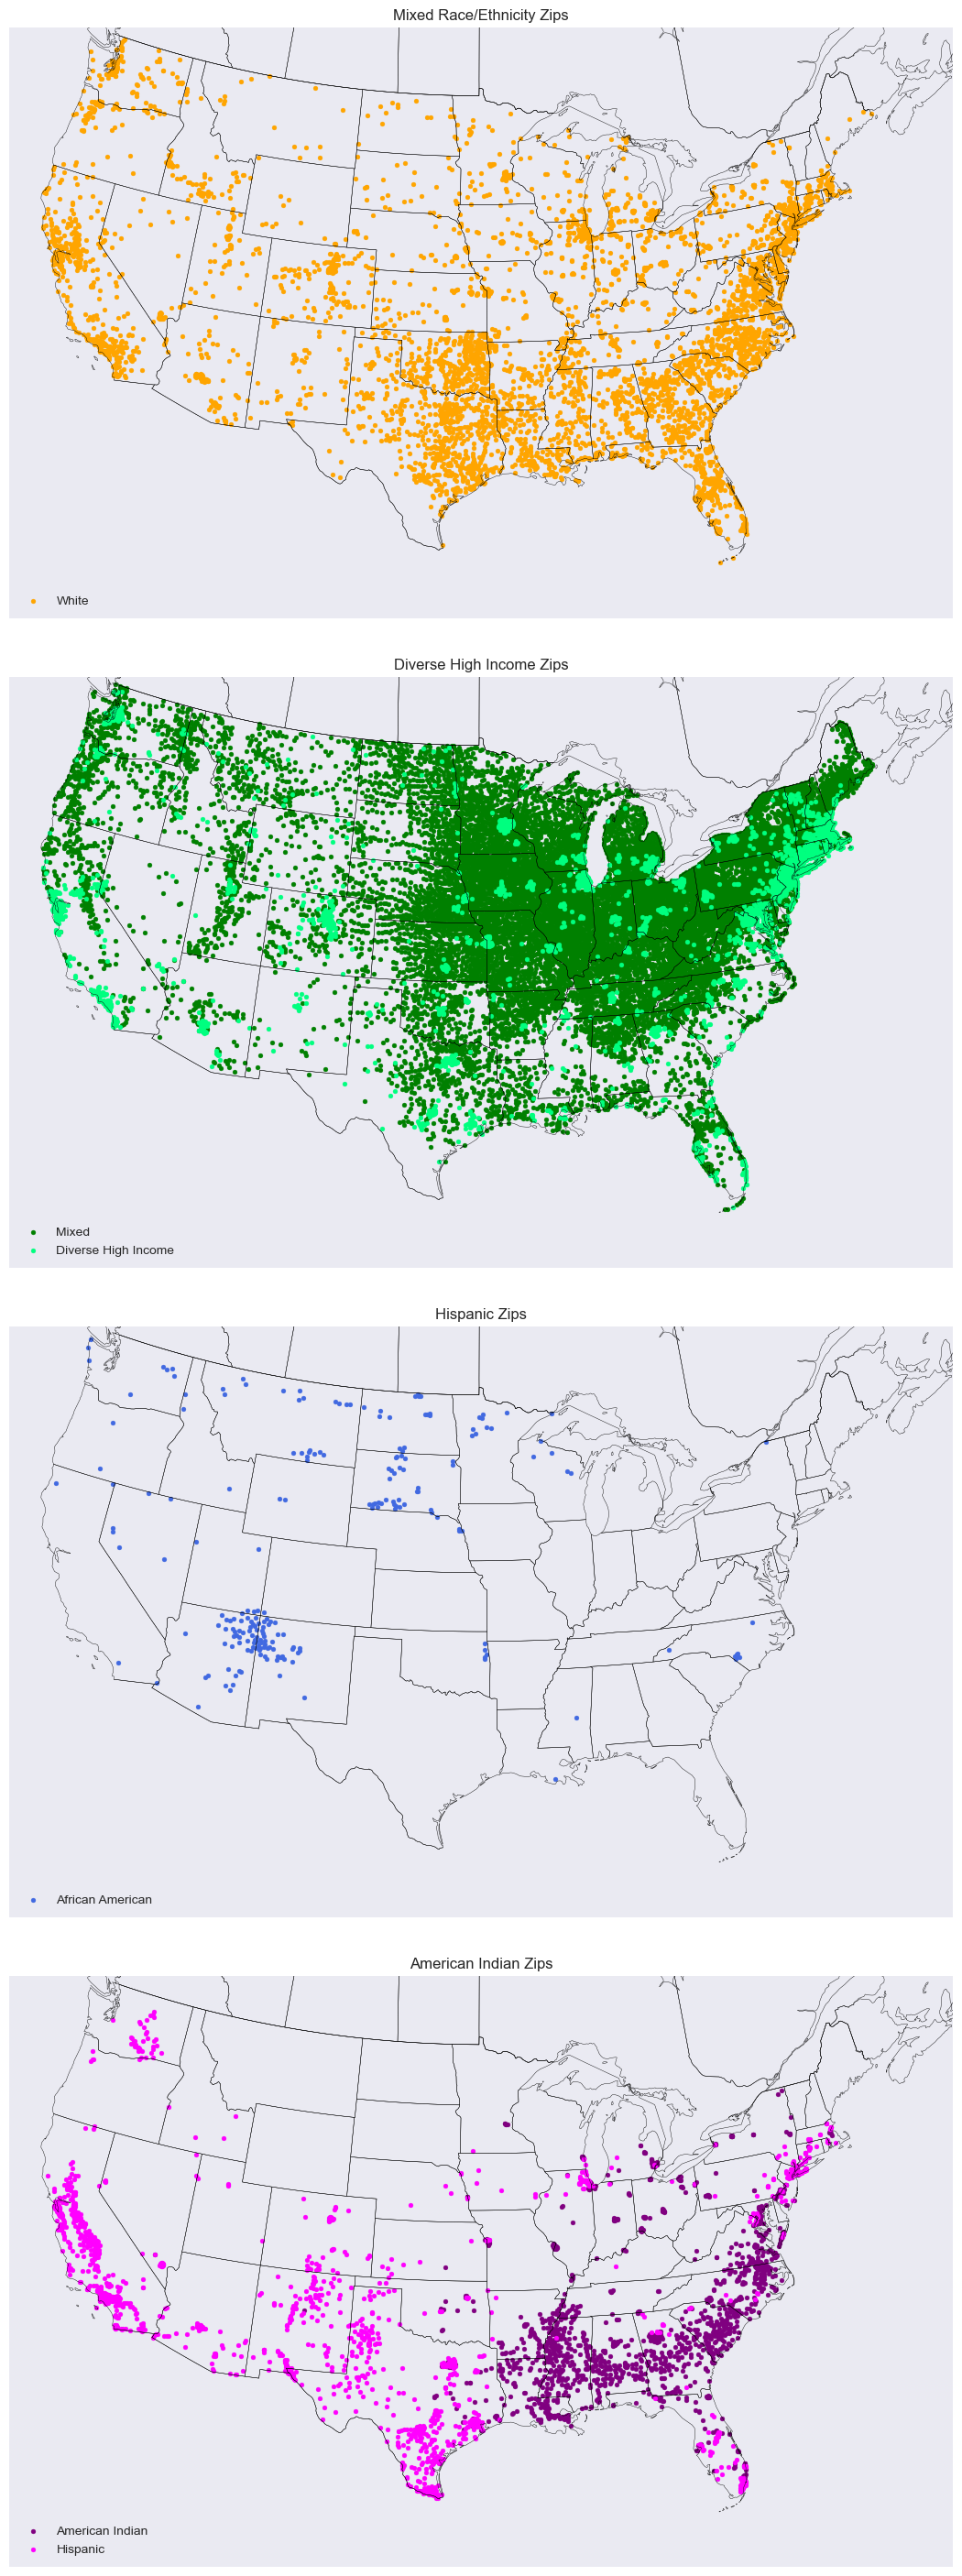

In [31]:
# Cluster 5 - "White"
# Cluster 0 - "Mixed Race/Ethnicity"
# Cluster 1 - "DiverseHighIncomeHighEducation"
# Cluster 4 - "African American"
# Cluster 3 - "American Indian"
# Cluster 2 - "Hispanic"


gp=geoplotstates(figsize=(18,36))

colors=[['orange'],['green','springgreen'], ['royalblue'] ,['purple','magenta']]
clabels=[[5],[0,1], [4], [3,2]]
markers=[['.'], ['.','.'], ['.'], ['.','.']]
labels=[['White'],['Mixed','Diverse High Income'] , ['African American'],['American Indian', 'Hispanic']]
title = demographic_labels

for k in range(0,4):
    ax = ax=gp.stateplot(subplot=(4,1,k+1))
    t=title[k]
    for clabel,color,marker,label in zip(clabels[k],colors[k],markers[k],labels[k]):
        lats=XZLLL.loc[XZLLL['clabel']==clabel][['Latitude']].values
        longs=XZLLL.loc[XZLLL['clabel']==clabel][['Longitude']].values
        ax.scatter(longs,lats, transform=ccrs.PlateCarree() , marker =  marker , c=color,label=label )
        ax.set_title(t)
        ax.legend(loc='lower left' )

plt.show()

# Geo Map Industry Zip Codes

Industry geo data preparation


 data_census/zipcitystatelatlong.csv


,ZipCode,City,State,Latitude,Longitude
0,71937,Cove,AR,34.398483,-94.39398
1,72044,Edgemont,AR,35.624351,-92.16056
2,56171,Sherburn,MN,43.660847,-94.74357


,ZipCode,AggFarmFishMingPercent,ConstructionPercent,ManufacturingPercent,WholesaleTradePercent,EducationHealthcareSocialPercent,RetailTradePercent,TransportationWarehouseUtilitiesPercent,ArtsEntertainmentRecAccomFoodPercent,OtherPercent,InformationPercent,FinanceInsuranceRealestateRentalPercent,PublicAdminPercent,clabel,City,State,Latitude,Longitude
0,01001,0.000000,4.466213,14.627262,2.639880,25.037357,12.170015,8.135481,4.366595,2.008966,1.942554,7.554375,5.562012,0,Agawam,MA,42.070610,-72.62029
1,01002,0.046325,4.663372,4.122915,2.192712,50.185300,8.199506,3.242742,6.578135,3.196418,1.266214,3.520692,2.130945,2,Amherst,MA,42.377651,-72.50323
2,01003,7.222222,0.000000,0.000000,0.000000,24.444444,12.777778,0.000000,28.888889,8.888889,0.000000,6.666667,0.000000,0,Amherst,MA,42.369562,-72.63599


Suburban Zips          18618
Rural-suburban Zips     2328
Rural Zips              3118
Manufacturing Zips      8167
Name: ZipCode, dtype: int64

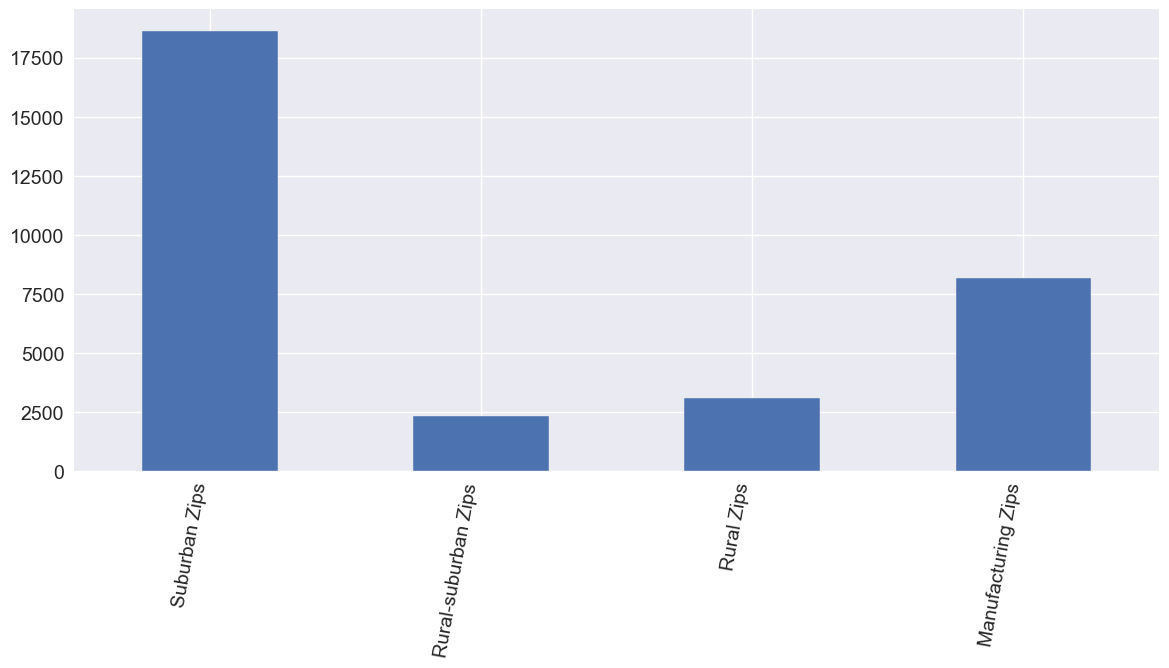

In [33]:
# Data Prep for Geo Maps
#   XZ2L row information, with Zip Code, and Cluster Labels
#   XZ2LLL row information, with Zip Code, Cluster Labels, Lats, and Longs
XZ2L = XZ2.copy()
XZ2L['clabel']=clabels2


# Load Zip City State Lat Long 
read_filename='data_census/zipcitystatelatlong.csv'
print('\n', read_filename)
df_zipcitystatelatlong= pd.read_csv(read_filename, dtype={'ZipCode': str})
display(df_zipcitystatelatlong.head(3))


# join  zips infor with zip lat long
XZ2LLL=XZ2L.set_index('ZipCode').join(df_zipcitystatelatlong.set_index('ZipCode')).reset_index()

display(XZ2LLL.head(3))




XZ_label_count=XZ2LLL.groupby('clabel')['ZipCode'].count()
XZ_label_count.index  = industry_labels
display(XZ_label_count.head())


matplotlib.style.use('seaborn')
g = XZ_label_count.plot(kind='bar', figsize=[14,6])
g.set_xticklabels(g.get_xticklabels(), rotation=80, horizontalalignment='right', size=14)
plt.yticks(fontsize=14)
plt.show()

## Discussion: Industry Zip Code Geo Plots

* Suburban -  Education Healthcare Social with some Industry (cluster 0)
  * As observed in the bar chart above, this is the largest cluster (most number of Zip Codes) and as observed from the Geo Plot it spans the entire United states. These zip codes apear to be suburbs with some light industry, such as retail, and education. 
* Rural-suburban - Education Healtchare Social Zips (Cluster 1)
  * Like Cluster 0, these zip codes also span the United States, but have lighter industry, less number of schools and industry activity in general. These are more rurual than cluster 0.
* Rurual - Aggriculture Farming Fishing Zips (Cluster 2) 
  * This cluster has the least amount of industrialization. The main industry is Agriculture. The cluster has significantly less education industry and health care indicating that these zip codes are rurual.
* Manufacturing (Cluster 3) 
  * This cluster has high percentage of manufaturing with most zip codes located from east to mid-west. There is significantly less manufacturing in the west, but West Coast showing slightly more manufacturing zip codes than the western states.

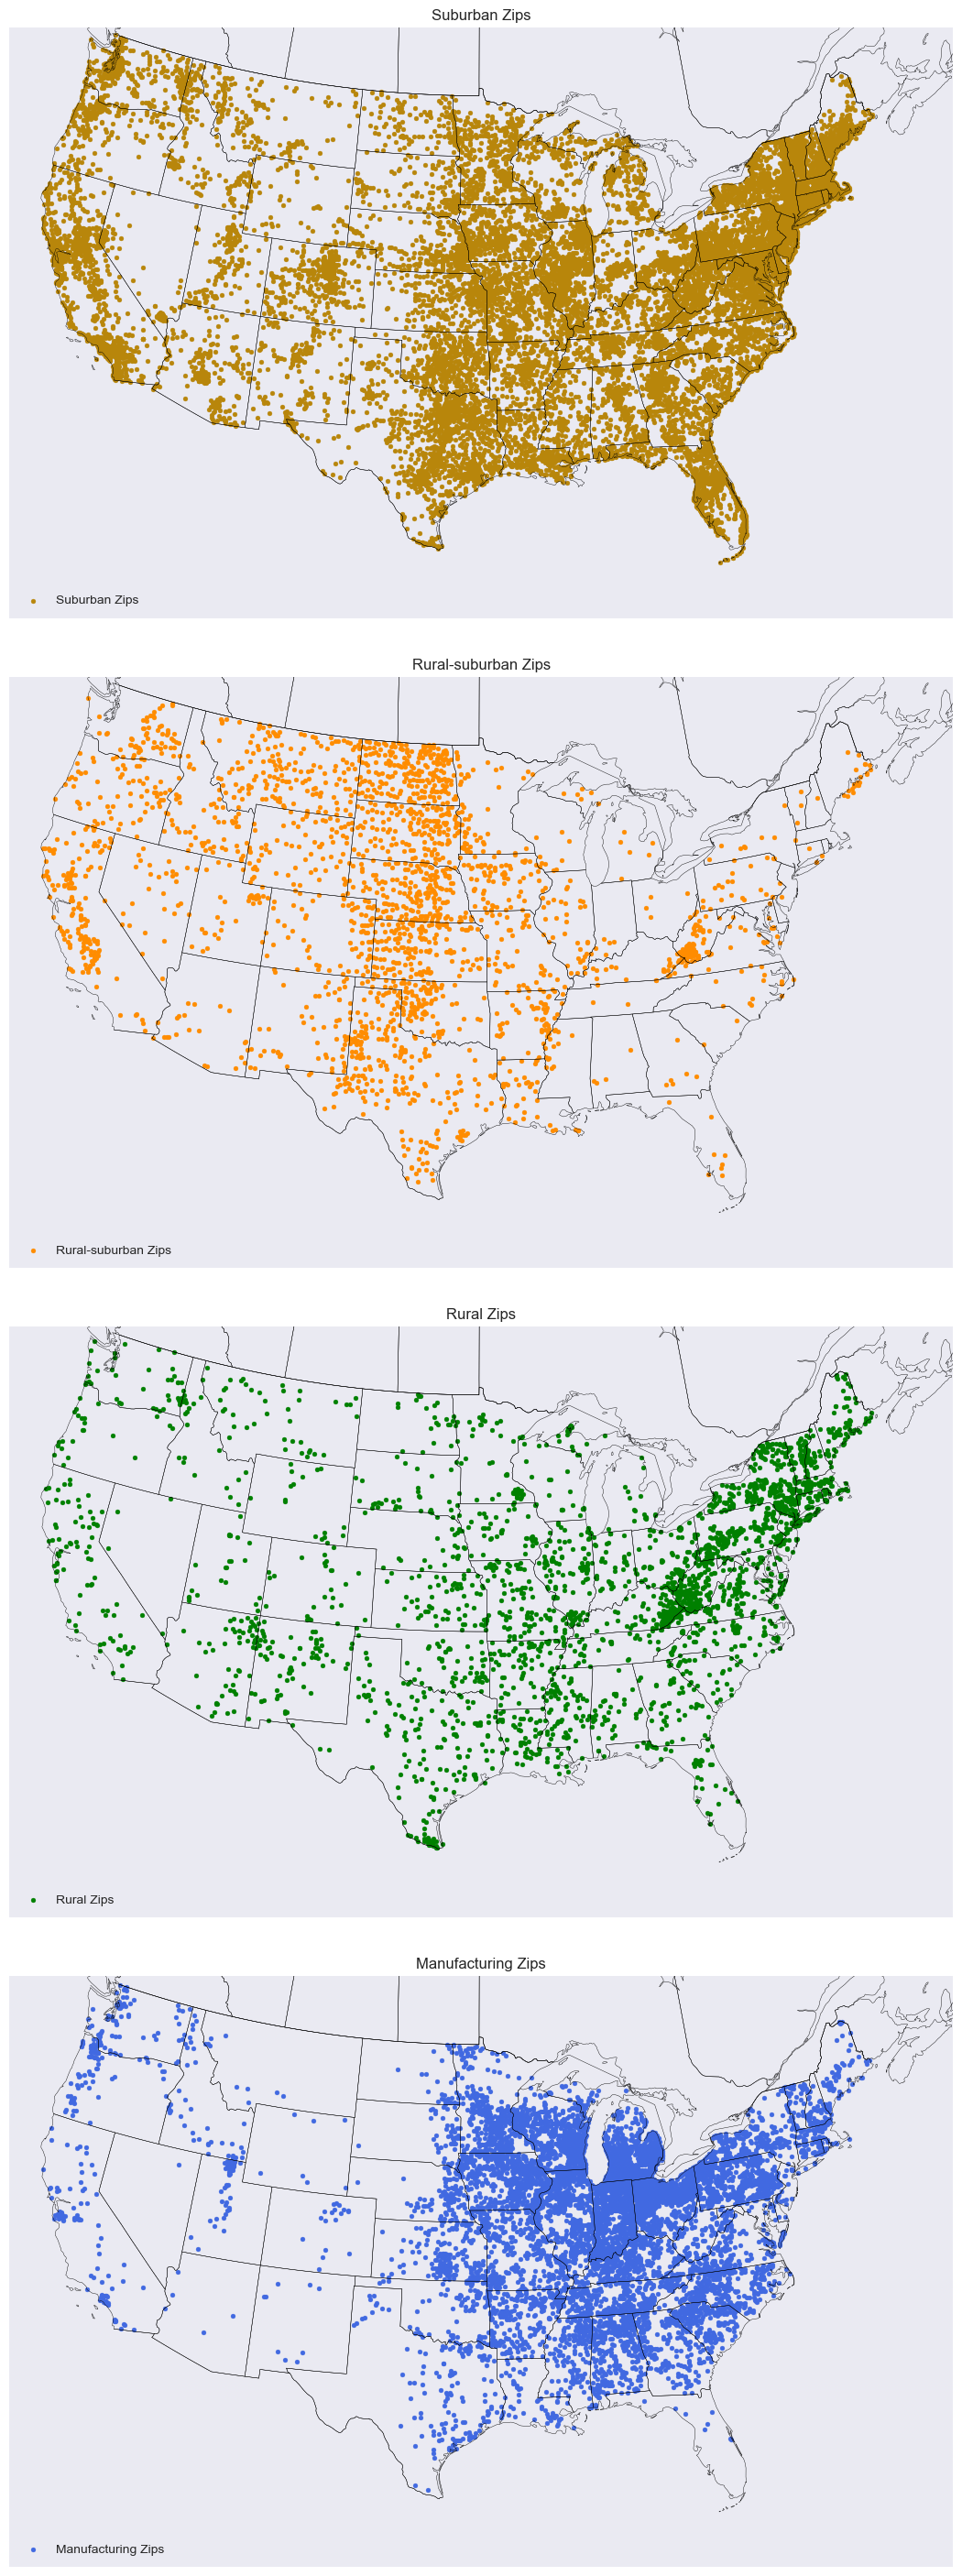

In [34]:
gp=geoplotstates(figsize=(18,36))


colors=['darkgoldenrod','darkorange','green','royalblue']
clabels=[0,1,2,3] 
markers=['.','.','.','.']
titles = industry_labels
for clabel,color,marker,title,k in zip(clabels,colors,markers,titles,range(1,7)):
    ax=gp.stateplot(subplot=(4,1,k))
    lats=XZ2LLL.loc[XZ2LLL['clabel']==clabel][['Latitude']].values
    longs=XZ2LLL.loc[XZ2LLL['clabel']==clabel][['Longitude']].values
    ax.scatter(longs,lats, transform=ccrs.PlateCarree() , marker =  marker, c=color, label=title)
    ax.set_title(title)
    ax.legend(loc='lower left' )
